In [1]:
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

In [2]:
from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load data (reusing from previous notebooks)
df, concepts = load_and_prepare_data("../data/final_dataset.csv")

print("RQ4: Understanding Intervention Mechanisms")
print("="*60)
print(f"Sample size: {len(df)}")

RQ4: Understanding Intervention Mechanisms
Sample size: 1232


In [14]:
# =============================================================================
# 1. DEFINE MECHANISMS AND LABELS (COMBINED)
# =============================================================================

# Define mechanisms with labels in one step
mechanism_config = {
    'Self-Determination': {
        'autonomy_need_satisfaction': 'Autonomy Satisfaction',
        'autonomy_need_frustration': 'Autonomy Frustration', 
        'competence_need_satisfaction': 'Competence Satisfaction',
        'competence_need_frustration': 'Competence Frustration',
        'relatedness_need_satisfaction': 'Relatedness Satisfaction',
        'relatedness_need_frustration': 'Relatedness Frustration'
    },
    'Cognitive_Dissonance': {
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement'
    },
    'Social_Norms': {
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms', 
        'reference_group_identification': 'Perceived Reference Group Identification',
        'social_sanctions': 'Perceived Social Sanctions'
    },
    'Self_Efficacy': {
        'performance_accomplishments': 'Perceived Performance Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal'
    },
    'Perceived_Effectiveness': {
        'PME_on_honest_task_completion': 'Perceived Message Effectiveness\non Honest Task Completion',
        'PME_on_task_performance': 'Perceived Message Effectiveness\non Performance',
        'PME_on_task_experience': 'Perceived Message Effectiveness\non User Experience'
    },
    # 'Individual_Factors': {
    #     'perceived_ability': 'Perceived Ability'
    # }
}

# Handle perceived_ability mapping and create available mechanisms list
# if 'word_creation_skill_level' in df.columns:
#     df['perceived_ability'] = df['word_creation_skill_level']

# Extract available mechanisms and labels in one pass
available_mechanisms = []
mechanism_labels = {}
for theory, mechs in mechanism_config.items():
    for mech_var, mech_label in mechs.items():
        if mech_var in df.columns:
            available_mechanisms.append(mech_var)
            mechanism_labels[mech_var] = mech_label

print(f"Available mechanisms: {len(available_mechanisms)}")

Available mechanisms: 19


RQ3.1: Do interventions activate their intended mechanisms?
Total intervention-mechanism pairs analyzed: 15


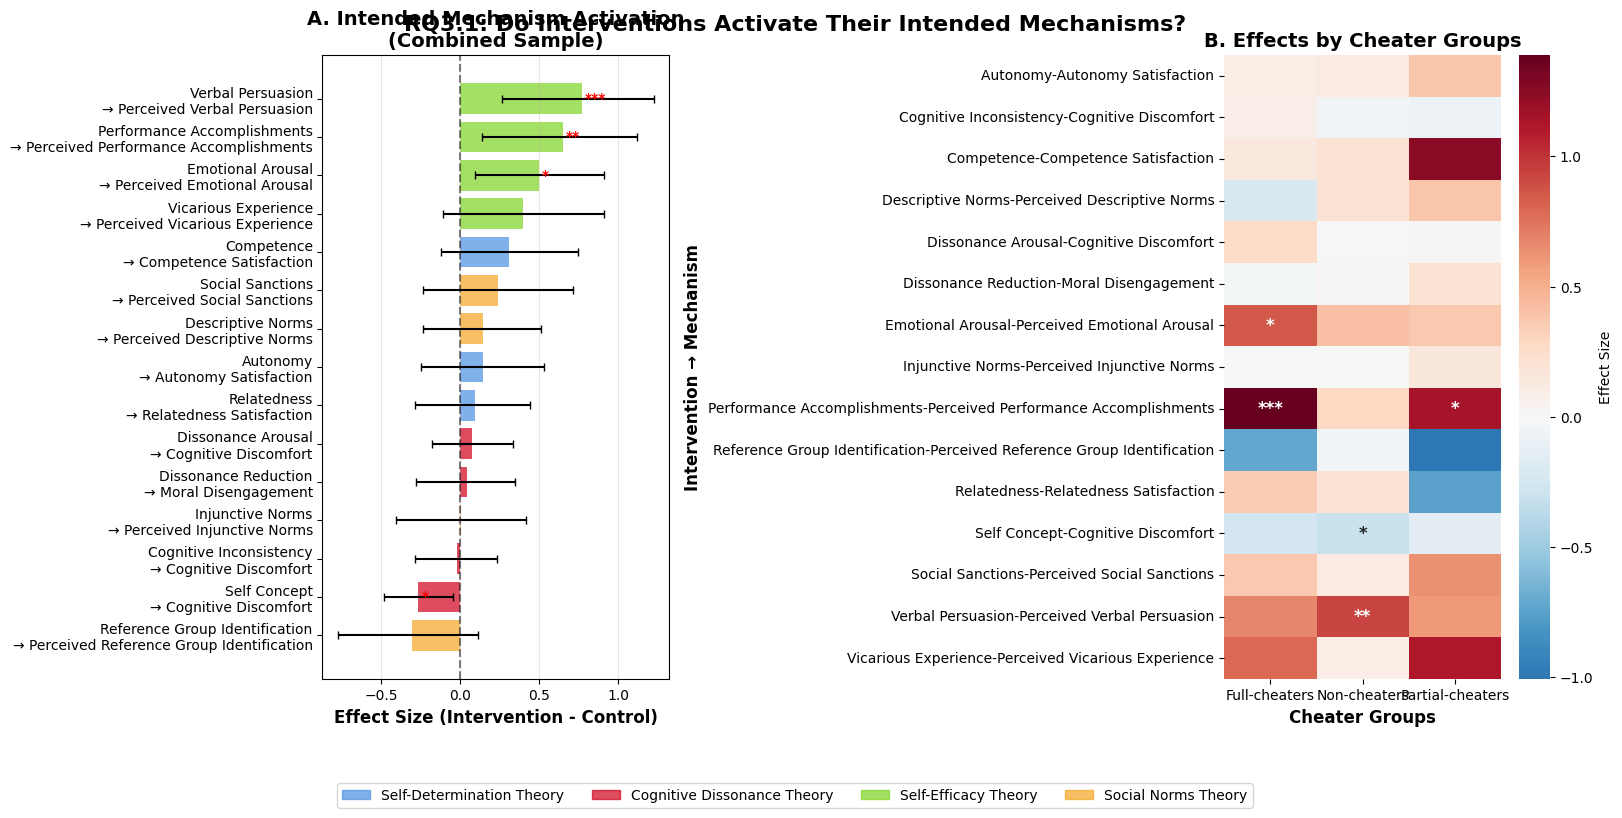


SUMMARY STATISTICS:
Combined sample significant effects: 4/15
Group-level significant effects: 5/45

Results saved to: intended_mechanism_results.csv


In [15]:
# =============================================================================
# RQ3.1: DO INTERVENTIONS ACTIVATE THEIR INTENDED MECHANISMS?
# =============================================================================

# Define intervention-mechanism matches based on theory
intervention_mechanism_matches = {
    # Self-Determination Theory
    'autonomy': ['autonomy_need_satisfaction'],
    'competence': ['competence_need_satisfaction'], 
    'relatedness': ['relatedness_need_satisfaction'],
    
    # Cognitive Dissonance Theory
    'self_concept': ['cognitive_discomfort'],
    'cognitive_inconsistency': ['cognitive_discomfort'],
    'dissonance_arousal': ['cognitive_discomfort'],
    'dissonance_reduction': ['moral_disengagement'],
    
    # Self-Efficacy Theory
    'performance_accomplishments': ['performance_accomplishments'],
    'vicarious_experience': ['vicarious_experience'],
    'verbal_persuasion': ['verbal_persuasion'],
    'emotional_arousal': ['emotional_arousal'],
    
    # Social Norms Theory
    'descriptive_norms': ['descriptive_norms'],
    'injunctive_norms': ['injunctive_norms'],
    'social_sanctions': ['social_sanctions'],
    'reference_group_identification': ['reference_group_identification']
}

def analyze_intended_mechanisms(df, matches):
    """Analyze whether interventions activate their intended mechanisms"""
    results = []
    
    for intervention, mechanisms in matches.items():
        if intervention not in df['concept'].values:
            continue
            
        # Get intervention and control data
        intervention_mask = (df['concept'] == intervention)
        control_mask = (df['concept'] == 'control')
        
        for mechanism in mechanisms:
            if mechanism not in df.columns:
                continue
                
            # Combined analysis
            control_vals = df[control_mask][mechanism].dropna()
            intervention_vals = df[intervention_mask][mechanism].dropna()
            
            if len(control_vals) > 5 and len(intervention_vals) > 5:
                effect_size, ci_low, ci_high, p_value = bootstrap_ci_diff(
                    control_vals.values, intervention_vals.values, n_boot=1000
                )
                
                results.append({
                    'intervention': intervention.replace('_', ' ').title(),
                    'mechanism': mechanism_labels.get(mechanism, mechanism),
                    'theory': theory_map.get(intervention, 'Other'),
                    'group': 'Combined',
                    'effect_size': effect_size,
                    'ci_low': ci_low,
                    'ci_high': ci_high,
                    'p_value': p_value,
                    'n_control': len(control_vals),
                    'n_intervention': len(intervention_vals)
                })
                
                # By cheater groups
                for g_idx, group_name in enumerate(['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']):
                    group_mask = (df['cheating_behavior'] == g_idx)
                    
                    control_group = df[control_mask & group_mask][mechanism].dropna()
                    intervention_group = df[intervention_mask & group_mask][mechanism].dropna()
                    
                    if len(control_group) > 3 and len(intervention_group) > 3:
                        effect_size, ci_low, ci_high, p_value = bootstrap_ci_diff(
                            control_group.values, intervention_group.values, n_boot=1000
                        )
                        
                        results.append({
                            'intervention': intervention.replace('_', ' ').title(),
                            'mechanism': mechanism_labels.get(mechanism, mechanism),
                            'theory': theory_map.get(intervention, 'Other'),
                            'group': group_name,
                            'effect_size': effect_size,
                            'ci_low': ci_low,
                            'ci_high': ci_high,
                            'p_value': p_value,
                            'n_control': len(control_group),
                            'n_intervention': len(intervention_group)
                        })
    
    return pd.DataFrame(results)

# Run analysis
print("RQ3.1: Do interventions activate their intended mechanisms?")
print("=" * 70)

intended_results = analyze_intended_mechanisms(df, intervention_mechanism_matches)
print(f"Total intervention-mechanism pairs analyzed: {len(intended_results[intended_results['group'] == 'Combined'])}")

def create_intended_mechanism_figure(results_df):
    """Create 2-panel manuscript figure for RQ3.1"""
    
    # Prepare data
    combined_data = results_df[results_df['group'] == 'Combined'].copy()
    group_data = results_df[results_df['group'] != 'Combined'].copy()
    
    # Add significance markers
    def get_sig_marker(p_val):
        if p_val < 0.001: return '***'
        elif p_val < 0.01: return '**'
        elif p_val < 0.05: return '*'
        else: return ''
    
    combined_data['sig'] = combined_data['p_value'].apply(get_sig_marker)
    group_data['sig'] = group_data['p_value'].apply(get_sig_marker)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Panel A: Combined Sample Horizontal Bar Chart
    if not combined_data.empty:
        combined_data = combined_data.sort_values('effect_size', ascending=True)
        
        # Create labels with theory grouping
        labels = []
        colors = []
        theory_colors = {'Self-Determination Theory': '#4A90E2', 'Cognitive Dissonance Theory': '#D0021B', 
                        'Self-Efficacy Theory': '#7ED321', 'Social Norms Theory': '#F5A623'}
        
        for _, row in combined_data.iterrows():
            labels.append(f"{row['intervention']}\n→ {row['mechanism']}")
            colors.append(theory_colors.get(row['theory'], '#BBBBBB'))
        
        y_pos = np.arange(len(labels))
        
        # Plot bars with error bars
        ax1.barh(y_pos, combined_data['effect_size'], color=colors, alpha=0.7, 
                xerr=[combined_data['effect_size'] - combined_data['ci_low'],
                      combined_data['ci_high'] - combined_data['effect_size']], 
                capsize=3, error_kw={'color': 'black', 'capthick': 1})
        
        # Add significance markers
        for i, (_, row) in enumerate(combined_data.iterrows()):
            if row['sig']:
                ax1.text(row['effect_size'] + 0.02, i, row['sig'], 
                        va='center', ha='left', fontweight='bold', color='red')
        
        ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(labels, fontsize=10)
        ax1.set_xlabel('Effect Size (Intervention - Control)', fontsize=12, fontweight='bold')
        ax1.set_title('A. Intended Mechanism Activation\n(Combined Sample)', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
    
    # Panel B: Cheater Group Heatmap
    if not group_data.empty:
        # Create pivot table for heatmap
        pivot_data = group_data.pivot_table(
            index=['intervention', 'mechanism'], 
            columns='group', 
            values='effect_size', 
            fill_value=0
        )
        
        # Create significance overlay
        sig_pivot = group_data.pivot_table(
            index=['intervention', 'mechanism'], 
            columns='group', 
            values='sig', 
            fill_value='', 
            aggfunc='first'
        )
        
        # Plot heatmap
        sns.heatmap(pivot_data, annot=sig_pivot, fmt='', cmap='RdBu_r', center=0,
                   cbar_kws={'label': 'Effect Size'}, ax=ax2, 
                   annot_kws={'fontsize': 12, 'fontweight': 'bold'})
        
        ax2.set_title('B. Effects by Cheater Groups', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Cheater Groups', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Intervention → Mechanism', fontsize=12, fontweight='bold')
        ax2.tick_params(axis='y', rotation=0)
    
    # Overall styling
    plt.suptitle('RQ3.1: Do Interventions Activate Their Intended Mechanisms?', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Add theory legend
    theory_handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7) 
                     for color in theory_colors.values()]
    fig.legend(theory_handles, theory_colors.keys(), 
              loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.15)
    plt.show()
    
    return combined_data, group_data

# Create visualization
combined_results, group_results = create_intended_mechanism_figure(intended_results)

# Print summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Combined sample significant effects: {len(combined_results[combined_results['sig'] != ''])}/{len(combined_results)}")
if not group_results.empty:
    print(f"Group-level significant effects: {len(group_results[group_results['sig'] != ''])}/{len(group_results)}")

# Save results
intended_results.to_csv('intended_mechanism_results.csv', index=False)
print(f"\nResults saved to: intended_mechanism_results.csv")

RQ3.2: Which mechanisms actually predict cheating reduction?
Using partial correlation analysis (controlling for interventions + other mechanisms)
Sample size for partial correlation analysis: 1159
Mechanisms successfully analyzed: 19
Group context data points: 57


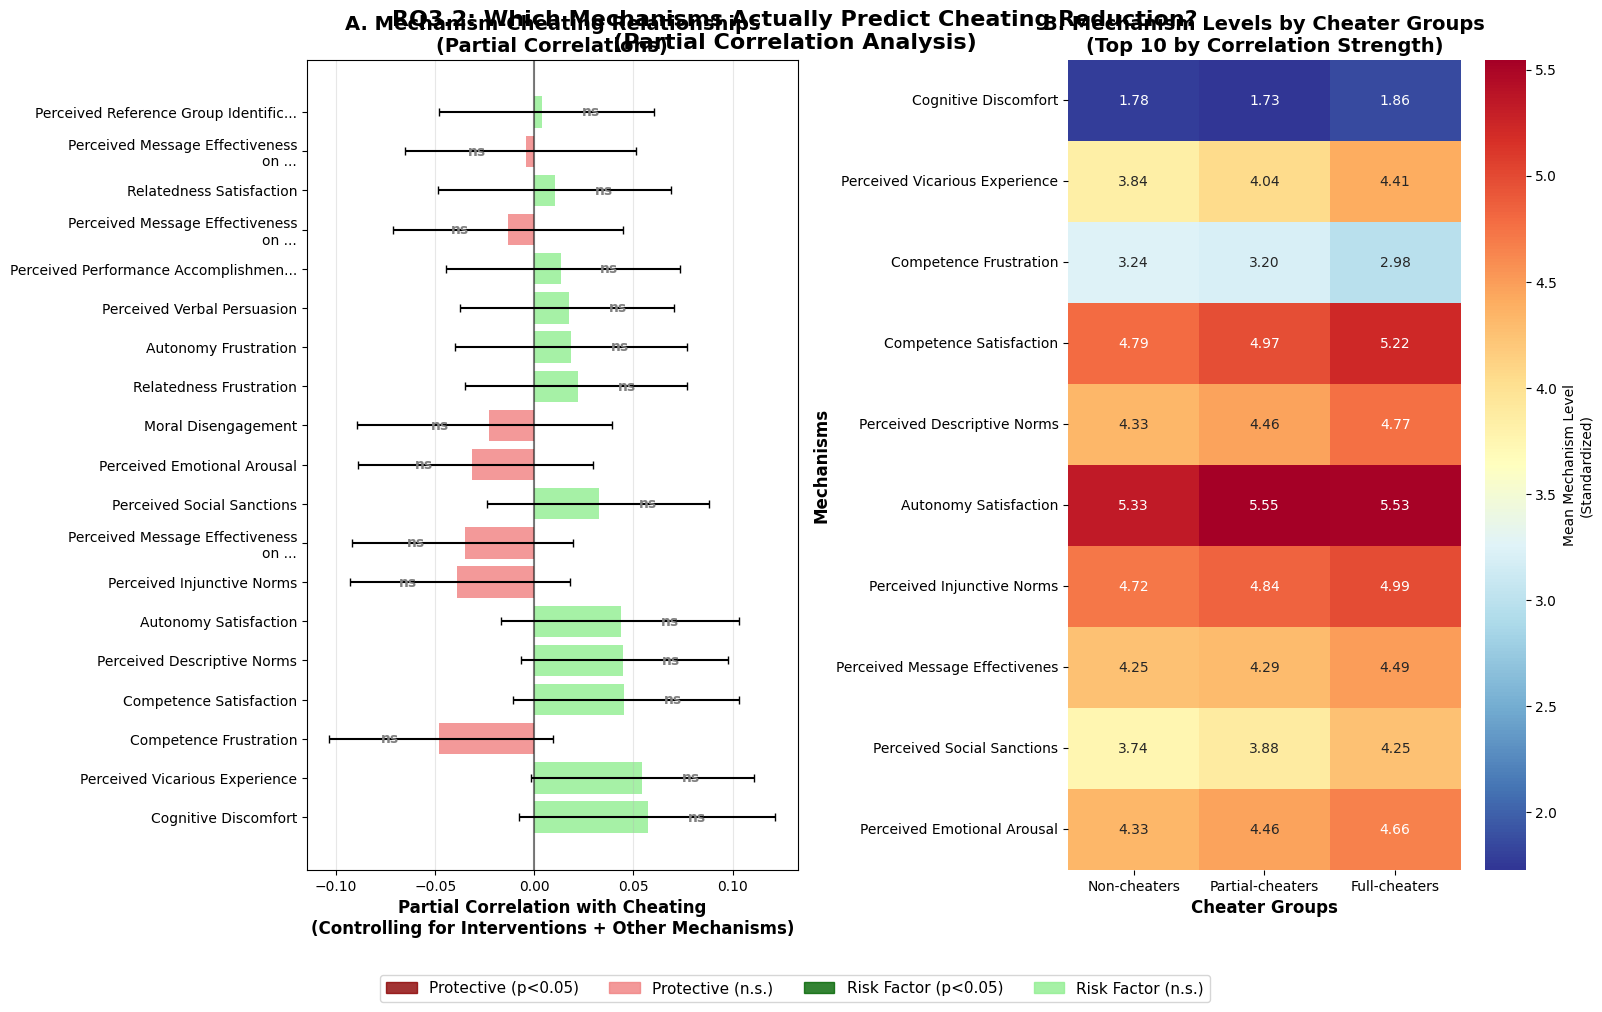


SUMMARY STATISTICS:
Total mechanisms analyzed: 19
Significant protective mechanisms: 0 (0.0%)
Significant risk mechanisms: 0 (0.0%)

TOP PROTECTIVE MECHANISMS (reduce cheating, controlling for other factors):
No significant protective mechanisms found

TOP RISK MECHANISMS (increase cheating, controlling for other factors):
No significant risk mechanisms found

Results saved to:
- mechanism_cheating_partial_correlations.csv
- mechanism_levels_by_groups.csv


In [16]:
# =============================================================================
# RQ3.2: WHICH MECHANISMS ACTUALLY PREDICT CHEATING REDUCTION?
# =============================================================================

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def partial_correlation(x, y, controls):
    """Calculate partial correlation controlling for other variables"""
    reg_x = LinearRegression().fit(controls, x)
    reg_y = LinearRegression().fit(controls, y)
    res_x = x - reg_x.predict(controls)
    res_y = y - reg_y.predict(controls)
    return np.corrcoef(res_x, res_y)[0, 1]

def analyze_mechanism_cheating_partial_correlations(df):
    """Analyze mechanism-cheating relationships using partial correlations"""
    
    # Use intervention data only (exclude control)
    df_intervention = df[df['concept'] != 'control'].copy()
    
    # Create concept dummy variables for controlling
    for concept in concepts:
        df_intervention[f'concept_{concept}'] = (df_intervention['concept'] == concept).astype(int)
    
    # Prepare variables
    concept_vars = [f'concept_{c}' for c in concepts if f'concept_{c}' in df_intervention.columns]
    outcome_vars = ['cheating_behavior', 'performance', 'experience']
    all_vars = concept_vars + available_mechanisms + outcome_vars
    
    # Clean data
    df_clean = df_intervention.dropna(subset=all_vars).copy()
    
    # Standardize continuous variables (mechanisms and continuous outcomes)
    scaler = StandardScaler()
    continuous_vars = [m for m in available_mechanisms if m in df_clean.columns] + ['performance', 'experience']
    df_clean[continuous_vars] = scaler.fit_transform(df_clean[continuous_vars])
    
    print(f"Sample size for partial correlation analysis: {len(df_clean)}")
    
    # Prepare data matrix
    X_all = df_clean[all_vars].values
    results = []
    
    # Calculate partial correlations: mechanism → cheating (controlling for concepts + other mechanisms)
    cheating_idx = len(concept_vars) + len(available_mechanisms)  # Index of cheating_behavior
    
    for i, mechanism in enumerate(available_mechanisms):
        if mechanism not in df_clean.columns:
            continue
            
        mechanism_idx = len(concept_vars) + i
        
        # Control variables: concepts + all other mechanisms (exclude current mechanism and cheating)
        control_indices = (list(range(len(concept_vars))) +  # concepts
                          [len(concept_vars) + j for j in range(len(available_mechanisms)) if j != i])  # other mechanisms
        
        try:
            # Partial correlation between mechanism and cheating, controlling for concepts + other mechanisms
            partial_corr = partial_correlation(
                X_all[:, mechanism_idx],  # current mechanism
                X_all[:, cheating_idx],   # cheating behavior
                X_all[:, control_indices] # control variables
            )
            
            if not np.isnan(partial_corr):
                # Bootstrap confidence interval for partial correlation
                bootstrap_corrs = []
                n_boot = 1000
                n_samples = len(X_all)
                
                for _ in range(n_boot):
                    boot_indices = np.random.choice(n_samples, n_samples, replace=True)
                    boot_X = X_all[boot_indices]
                    
                    try:
                        boot_corr = partial_correlation(
                            boot_X[:, mechanism_idx],
                            boot_X[:, cheating_idx],
                            boot_X[:, control_indices]
                        )
                        if not np.isnan(boot_corr):
                            bootstrap_corrs.append(boot_corr)
                    except:
                        continue
                
                if len(bootstrap_corrs) > 100:  # Sufficient bootstrap samples
                    ci_low = np.percentile(bootstrap_corrs, 2.5)
                    ci_high = np.percentile(bootstrap_corrs, 97.5)
                    
                    # Calculate p-value: proportion of bootstrap samples where correlation crosses zero
                    if partial_corr >= 0:
                        p_value = 2 * np.mean(np.array(bootstrap_corrs) <= 0)
                    else:
                        p_value = 2 * np.mean(np.array(bootstrap_corrs) >= 0)
                    p_value = min(p_value, 1.0)
                    
                    results.append({
                        'mechanism': mechanism_labels.get(mechanism, mechanism),
                        'raw_mechanism': mechanism,
                        'partial_correlation': partial_corr,
                        'ci_low': ci_low,
                        'ci_high': ci_high,
                        'p_value': p_value,
                        'sample_size': n_samples,
                        'effect_direction': 'Protective' if partial_corr < 0 else 'Risk Factor',
                        'bootstrap_samples': len(bootstrap_corrs)
                    })
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

def analyze_by_cheater_groups(df):
    """Analyze mechanism levels across cheater groups for context"""
    group_results = []
    
    for group_idx, group_name in enumerate(['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']):
        group_data = df[(df['concept'] != 'control') & (df['cheating_behavior'] == group_idx)]
        
        for mechanism in available_mechanisms:
            if mechanism in group_data.columns:
                mech_values = group_data[mechanism].dropna()
                if len(mech_values) > 5:
                    group_results.append({
                        'mechanism': mechanism_labels.get(mechanism, mechanism),
                        'raw_mechanism': mechanism,
                        'group': group_name,
                        'mean_level': np.mean(mech_values),
                        'std_level': np.std(mech_values),
                        'sample_size': len(mech_values)
                    })
    
    return pd.DataFrame(group_results)

def create_partial_correlation_figure(partial_results, group_results):
    """Create manuscript figure showing partial correlation results"""
    
    if len(partial_results) == 0:
        print("No partial correlation results to plot")
        return None, None
    
    # Add significance markers
    partial_results['significant'] = partial_results['p_value'] < 0.05
    partial_results['sig_marker'] = partial_results.apply(
        lambda x: '***' if x['p_value'] < 0.001 else 
                 ('**' if x['p_value'] < 0.01 else 
                 ('*' if x['p_value'] < 0.05 else 'ns')), axis=1
    )
    
    # Sort by absolute correlation strength
    partial_results_sorted = partial_results.reindex(
        partial_results['partial_correlation'].abs().sort_values(ascending=False).index
    )
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
    
    # Panel A: Partial Correlations with Cheating
    colors = ['darkred' if (corr < 0 and sig) else 'lightcoral' if corr < 0 else 
              'darkgreen' if (corr > 0 and sig) else 'lightgreen'
              for corr, sig in zip(partial_results_sorted['partial_correlation'], 
                                  partial_results_sorted['significant'])]
    
    y_pos = np.arange(len(partial_results_sorted))
    
    # Plot bars with error bars
    ax1.barh(y_pos, partial_results_sorted['partial_correlation'], color=colors, alpha=0.8,
            xerr=[partial_results_sorted['partial_correlation'] - partial_results_sorted['ci_low'],
                  partial_results_sorted['ci_high'] - partial_results_sorted['partial_correlation']], 
            capsize=3, error_kw={'color': 'black', 'capthick': 1})
    
    # Add significance markers
    for i, (_, row) in enumerate(partial_results_sorted.iterrows()):
        x_pos = row['partial_correlation'] + (0.02 if row['partial_correlation'] > 0 else -0.02)
        ax1.text(x_pos, i, row['sig_marker'], 
                ha='left' if row['partial_correlation'] > 0 else 'right', va='center',
                fontweight='bold', color='red' if row['significant'] else 'gray')
    
    ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([mech[:35] + '...' if len(mech) > 35 else mech 
                        for mech in partial_results_sorted['mechanism']], fontsize=10)
    ax1.set_xlabel('Partial Correlation with Cheating\n(Controlling for Interventions + Other Mechanisms)', 
                  fontsize=12, fontweight='bold')
    ax1.set_title('A. Mechanism-Cheating Relationships\n(Partial Correlations)', 
                 fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Panel B: Group differences for top mechanisms
    if len(group_results) > 0:
        # Select top 10 mechanisms by absolute correlation
        top_mechanisms = partial_results_sorted.head(10)['raw_mechanism'].tolist()
        
        # Create heatmap data
        heatmap_data = []
        heatmap_labels = []
        
        for mechanism in top_mechanisms:
            row_data = []
            for group in ['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']:
                group_subset = group_results[
                    (group_results['raw_mechanism'] == mechanism) & 
                    (group_results['group'] == group)
                ]
                if len(group_subset) > 0:
                    row_data.append(group_subset.iloc[0]['mean_level'])
                else:
                    row_data.append(0)
            heatmap_data.append(row_data)
            heatmap_labels.append(mechanism_labels.get(mechanism, mechanism)[:30])
        
        if heatmap_data:
            heatmap_df = pd.DataFrame(heatmap_data, 
                                     index=heatmap_labels,
                                     columns=['Non-cheaters', 'Partial-cheaters', 'Full-cheaters'])
            
            sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                       cbar_kws={'label': 'Mean Mechanism Level\n(Standardized)'}, ax=ax2)
            
            ax2.set_title('B. Mechanism Levels by Cheater Groups\n(Top 10 by Correlation Strength)', 
                         fontsize=14, fontweight='bold')
            ax2.set_xlabel('Cheater Groups', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Mechanisms', fontsize=12, fontweight='bold')
            ax2.tick_params(axis='y', rotation=0)
    else:
        ax2.text(0.5, 0.5, 'No group data\navailable', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12)
    
    # Overall title and legend
    plt.suptitle('RQ3.2: Which Mechanisms Actually Predict Cheating Reduction?\n(Partial Correlation Analysis)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, color='darkred', alpha=0.8, label='Protective (p<0.05)'),
        plt.Rectangle((0,0),1,1, color='lightcoral', alpha=0.8, label='Protective (n.s.)'),
        plt.Rectangle((0,0),1,1, color='darkgreen', alpha=0.8, label='Risk Factor (p<0.05)'),
        plt.Rectangle((0,0),1,1, color='lightgreen', alpha=0.8, label='Risk Factor (n.s.)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
               ncol=4, fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.12)
    plt.show()
    
    return partial_results_sorted, top_mechanisms

# Run the analysis
print("RQ3.2: Which mechanisms actually predict cheating reduction?")
print("Using partial correlation analysis (controlling for interventions + other mechanisms)")
print("=" * 80)

# Calculate partial correlations
partial_corr_results = analyze_mechanism_cheating_partial_correlations(df)
print(f"Mechanisms successfully analyzed: {len(partial_corr_results)}")

# Get group context data
group_context = analyze_by_cheater_groups(df)
print(f"Group context data points: {len(group_context)}")

# Create visualization
if len(partial_corr_results) > 0:
    sorted_results, top_mechs = create_partial_correlation_figure(partial_corr_results, group_context)
    
    # Print summary statistics
    significant_protective = partial_corr_results[
        (partial_corr_results['partial_correlation'] < 0) & (partial_corr_results['p_value'] < 0.05)
    ]
    significant_risk = partial_corr_results[
        (partial_corr_results['partial_correlation'] > 0) & (partial_corr_results['p_value'] < 0.05)
    ]
    
    print(f"\nSUMMARY STATISTICS:")
    print(f"Total mechanisms analyzed: {len(partial_corr_results)}")
    print(f"Significant protective mechanisms: {len(significant_protective)} ({len(significant_protective)/len(partial_corr_results)*100:.1f}%)")
    print(f"Significant risk mechanisms: {len(significant_risk)} ({len(significant_risk)/len(partial_corr_results)*100:.1f}%)")
    
    print(f"\nTOP PROTECTIVE MECHANISMS (reduce cheating, controlling for other factors):")
    if len(significant_protective) > 0:
        top_protective = significant_protective.nsmallest(5, 'partial_correlation')
        for i, (_, row) in enumerate(top_protective.iterrows(), 1):
            print(f"{i}. {row['mechanism']}: r = {row['partial_correlation']:.3f} [{row['ci_low']:.3f}, {row['ci_high']:.3f}], p = {row['p_value']:.3f}")
    else:
        print("No significant protective mechanisms found")
    
    print(f"\nTOP RISK MECHANISMS (increase cheating, controlling for other factors):")
    if len(significant_risk) > 0:
        top_risk = significant_risk.nlargest(5, 'partial_correlation')
        for i, (_, row) in enumerate(top_risk.iterrows(), 1):
            print(f"{i}. {row['mechanism']}: r = {row['partial_correlation']:.3f} [{row['ci_low']:.3f}, {row['ci_high']:.3f}], p = {row['p_value']:.3f}")
    else:
        print("No significant risk mechanisms found")
    
    # Save results
    partial_corr_results.to_csv('mechanism_cheating_partial_correlations.csv', index=False)
    group_context.to_csv('mechanism_levels_by_groups.csv', index=False)
    print(f"\nResults saved to:")
    print(f"- mechanism_cheating_partial_correlations.csv")
    print(f"- mechanism_levels_by_groups.csv")
    
else:
    print("No partial correlation results obtained. Check data availability and preprocessing.")

In [ ]:
# =============================================================================
# 2. VIOLIN PLOTS - THEORY-SPECIFIC MECHANISMS VS CHEATING BEHAVIOR
# =============================================================================

def bootstrap_ci_diff(control, intervention, n_boot=5000, ci=95):
    """Bootstrap difference of means with CI and p-value."""
    n_control = len(control)
    n_intervention = len(intervention)
    
    # Bootstrap resampling
    diffs = []
    for _ in range(n_boot):
        boot_control = control[np.random.choice(n_control, n_control, replace=True)]
        boot_intervention = intervention[np.random.choice(n_intervention, n_intervention, replace=True)]
        diffs.append(np.mean(boot_intervention) - np.mean(boot_control))
    
    diffs = np.array(diffs)
    
    # Calculate p-value (proportion of bootstrap samples where effect crosses zero)
    observed_diff = np.mean(intervention) - np.mean(control)
    if observed_diff >= 0:
        p_value = 2 * np.mean(diffs <= 0)
    else:
        p_value = 2 * np.mean(diffs >= 0)
    p_value = min(p_value, 1.0)
    
    # Calculate confidence interval
    alpha = (100 - ci) / 2
    ci_low = np.percentile(diffs, alpha)
    ci_high = np.percentile(diffs, 100 - alpha)
    
    return observed_diff, ci_low, ci_high, p_value, diffs


def create_theory_violin_plots(df, theory_dict, mechanism_labels):
    """Enhanced violin plots with theory-specific color schemes and p-values."""
    
    cheat_groups = ['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']
    
    # Define theory-specific color palettes
    color_schemes = {
        "Self-Determination Mechanisms": {
            # Autonomy: Blue shades (freedom/choice)
            "autonomy_need_satisfaction": "#4A90E2",      # Bright blue
            "autonomy_need_frustration": "#1F4E79",       # Dark blue
            # Competence: Green shades (growth/achievement) 
            "competence_need_satisfaction": "#7ED321",    # Bright green
            "competence_need_frustration": "#2D5016",     # Dark green
            # Relatedness: Orange shades (warmth/connection)
            "relatedness_need_satisfaction": "#F5A623",   # Bright orange
            "relatedness_need_frustration": "#8B4513"     # Dark orange/brown
        },
        "Cognitive Dissonance Mechanisms": {
            "cognitive_discomfort": "#D0021B",
            "moral_disengagement": "#9013FE"
        },
        "Social Norms Mechanisms": {
            "descriptive_norms": "#50E3C2",
            "injunctive_norms": "#4A90E2", 
            "reference_group_identification": "#F5A623",
            "social_sanctions": "#D0021B"
        },
        "Self-Efficacy Mechanisms": {
            "performance_accomplishments": "#7ED321",
            "vicarious_experience": "#50E3C2",
            "verbal_persuasion": "#F5A623", 
            "emotional_arousal": "#BD10E0"
        },
        "Perceived Effectiveness Mechanisms": {
            "PME_on_honest_task_completion": "#4A90E2",
            "PME_on_task_performance": "#7ED321",
            "PME_on_task_experience": "#F5A623"
        },
        "Individual Differences": {
            "perceived_ability": "#9B9B9B"
        }
    }
    
    # Reuse existing masks
    control_mask = (df['concept'] == 'control')
    intervention_mask = (df['concept'] != 'control')

    for theory_name, mechanisms in theory_dict.items():
        plot_data = []
        stats_data = {}
        
        # Calculate statistics for each mechanism and group
        for mechanism in mechanisms:
            stats_data[mechanism] = {}
            for g_idx, group in enumerate(cheat_groups):
                group_mask = (df['cheating_behavior'] == g_idx)
                control_vals = df[control_mask & group_mask][mechanism].dropna().values
                intervention_vals = df[intervention_mask & group_mask][mechanism].dropna().values

                if len(control_vals) > 1 and len(intervention_vals) > 1:
                    mean_diff, ci_low, ci_high, p_value, boot_diffs = bootstrap_ci_diff(
                        control_vals, intervention_vals, n_boot=1000
                    )
                    
                    # Store statistics
                    stats_data[mechanism][group] = {
                        'mean': mean_diff,
                        'ci_low': ci_low,
                        'ci_high': ci_high,
                        'p_value': p_value
                    }
                    
                    # Add bootstrap samples for violin plot
                    for diff in boot_diffs:
                        plot_data.append({
                            'mechanism': mechanism_labels.get(mechanism, mechanism),
                            'group': group,
                            'effect': diff,
                            'raw_mechanism': mechanism
                        })

        if not plot_data:
            continue

        plot_df = pd.DataFrame(plot_data)
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create color palette for this theory
        theory_colors = color_schemes.get(theory_name, {})
        unique_mechs = plot_df['mechanism'].unique()
        mech_palette = {}
        for mech in unique_mechs:
            raw_mech = plot_df[plot_df['mechanism'] == mech]['raw_mechanism'].iloc[0]
            mech_palette[mech] = theory_colors.get(raw_mech, '#BBBBBB')

        # Create violin plot
        sns.violinplot(data=plot_df, x='group', y='effect', hue='mechanism',
                      split=False, cut=0, inner=None, palette=mech_palette, 
                      dodge=True, ax=ax, alpha=0.7)
        
        # Customize violin border colors
        for collection in ax.collections:
            collection.set_edgecolor('black')  # Change this to any color
            collection.set_linewidth(0)     # Adjust border thickness

        # Add means, CIs, and p-values
        n_hues = len(unique_mechs)
        hue_offsets = np.linspace(-0.4 + 0.4/n_hues, 0.4 - 0.4/n_hues, n_hues)

        for g_idx, group in enumerate(cheat_groups):
            for h_idx, mech in enumerate(unique_mechs):
                # Get raw mechanism name for stats lookup
                raw_mech = plot_df[plot_df['mechanism'] == mech]['raw_mechanism'].iloc[0]
                
                if raw_mech in stats_data and group in stats_data[raw_mech]:
                    stats = stats_data[raw_mech][group]
                    x_pos = g_idx + hue_offsets[h_idx]

                    # Plot mean + CI
                    ax.plot(x_pos, stats['mean'], 'o', color='white', markersize=4, 
                           markeredgecolor='black', markeredgewidth=2, zorder=4)
                    ax.vlines(x_pos, stats['ci_low'], stats['ci_high'], 
                             color='black', linewidth=1, zorder=3)

                    # Significance marker with p-value
                    is_significant = not (stats['ci_low'] <= 0 <= stats['ci_high'])
                    p_val = stats['p_value']
                    
                    if is_significant:
                        if p_val < 0.001:
                            sig_text = f"***\np<0.001"
                        elif p_val < 0.01:
                            sig_text = f"**\np={p_val:.3f}"
                        elif p_val < 0.05:
                            sig_text = f"*\np={p_val:.3f}"
                        else:
                            sig_text = f"p={p_val:.3f}"
                        sig_color = "#CC0000"
                    else:
                        # sig_text = f"n.s.\np={p_val:.3f}"
                        sig_text = f"n.s."
                        sig_color = "#666666"
                    
                    y_pos = max(stats['ci_high'], stats['mean']) + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                    ax.text(x_pos, y_pos, sig_text, ha='center', va='bottom',
                            fontsize=10, fontweight='bold', color=sig_color)

        # Styling
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.set_title(f"{theory_name}: Intervention − Control Effects",
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_ylabel("Effect Size (Intervention − Control)", fontsize=13, fontweight='bold')
        ax.set_xlabel("Cheating Groups", fontsize=13, fontweight='bold')
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=13, title_fontsize=14,
                 bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
        
        plt.tight_layout()
        plt.show()
        
theory_dict = {
    "Self-Determination Mechanisms": [
        "autonomy_need_satisfaction", "autonomy_need_frustration",
        "competence_need_satisfaction", "competence_need_frustration", 
        "relatedness_need_satisfaction", "relatedness_need_frustration"
    ],
    "Cognitive Dissonance Mechanisms": [
        "cognitive_discomfort", "moral_disengagement"
    ],
    "Social Norms Mechanisms": [
        "descriptive_norms", "injunctive_norms", 
        "reference_group_identification", "social_sanctions"
    ],
    "Self-Efficacy Mechanisms": [
        "performance_accomplishments", "vicarious_experience",
        "verbal_persuasion", "emotional_arousal"
    ],
    "Perceived Effectiveness Mechanisms": [
        "PME_on_honest_task_completion", "PME_on_task_performance", 
        "PME_on_task_experience"
    ],
    "Individual Differences": [
        "perceived_ability"
    ]
}

# Create plots using existing variables
create_theory_violin_plots(df, theory_dict, mechanism_labels)

In [4]:
# =============================================================================
# STATISTICAL TABLES FOR THEORY MECHANISMS (CONTROL VS INTERVENTION)
# =============================================================================

# Load and preprocess data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")

# Handle perceived_ability mapping
if 'word_creation_skill_level' in df.columns:
    df['perceived_ability'] = df['word_creation_skill_level']

# Define mechanisms and labels
mechanism_config = {
    'Self-Determination': {
        'autonomy_need_satisfaction': 'Autonomy Satisfaction',
        'autonomy_need_frustration': 'Autonomy Frustration', 
        'competence_need_satisfaction': 'Competence Satisfaction',
        'competence_need_frustration': 'Competence Frustration',
        'relatedness_need_satisfaction': 'Relatedness Satisfaction',
        'relatedness_need_frustration': 'Relatedness Frustration'
    },
    'Cognitive_Dissonance': {
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement'
    },
    'Social_Norms': {
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms', 
        'reference_group_identification': 'Perceived Reference Group Identification',
        'social_sanctions': 'Perceived Social Sanctions'
    },
    'Self_Efficacy': {
        'performance_accomplishments': 'Perceived Performance Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal'
    },
    'Perceived_Effectiveness': {
        'PME_on_honest_task_completion': 'Perceived Effect on Honesty',
        'PME_on_task_performance': 'Perceived Effect on Performance',
        'PME_on_task_experience': 'Perceived Effect on Experience'
    },
    'Individual_Factors': {
        'perceived_ability': 'Perceived Ability'
    }
}

# Extract available mechanisms and labels
available_mechanisms = []
mechanism_labels = {}
for theory, mechs in mechanism_config.items():
    for mech_var, mech_label in mechs.items():
        if mech_var in df.columns:
            available_mechanisms.append(mech_var)
            mechanism_labels[mech_var] = mech_label

# Bootstrap function for confidence intervals
def bootstrap_ci_diff(control, intervention, n_boot=5000, ci=95):
    """Bootstrap difference of means with CI and p-value."""
    n_control = len(control)
    n_intervention = len(intervention)
    
    # Bootstrap resampling
    diffs = []
    for _ in range(n_boot):
        boot_control = control[np.random.choice(n_control, n_control, replace=True)]
        boot_intervention = intervention[np.random.choice(n_intervention, n_intervention, replace=True)]
        diffs.append(np.mean(boot_intervention) - np.mean(boot_control))
    
    diffs = np.array(diffs)
    
    # Calculate p-value (proportion of bootstrap samples where effect crosses zero)
    observed_diff = np.mean(intervention) - np.mean(control)
    if observed_diff >= 0:
        p_value = 2 * np.mean(diffs <= 0)
    else:
        p_value = 2 * np.mean(diffs >= 0)
    p_value = min(p_value, 1.0)
    
    # Calculate confidence interval
    alpha = (100 - ci) / 2
    ci_low = np.percentile(diffs, alpha)
    ci_high = np.percentile(diffs, 100 - alpha)
    
    return observed_diff, ci_low, ci_high, p_value

# Prepare masks
control_mask = (df['concept'] == 'control')
intervention_mask = (df['concept'] != 'control')
cheat_groups = ['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']

def create_statistical_tables():
    """Create comprehensive statistical tables for all theory mechanisms."""
    
    print("="*100)
    print("STATISTICAL TABLES: THEORY MECHANISMS (CONTROL VS INTERVENTION)")
    print("="*100)
    print("Effect Size = Intervention Mean - Control Mean")
    print("95% CI = 95% Confidence Interval from Bootstrap (5000 iterations)")
    print("Significance: * p<0.05, ** p<0.01, *** p<0.001, n.s. = not significant")
    print("="*100)
    
    # Reorganize mechanism_config to match theory order used in plots
    theory_dict = {
        "Self-Determination Mechanisms": [
            "autonomy_need_satisfaction", "autonomy_need_frustration",
            "competence_need_satisfaction", "competence_need_frustration", 
            "relatedness_need_satisfaction", "relatedness_need_frustration"
        ],
        "Cognitive Dissonance Mechanisms": [
            "cognitive_discomfort", "moral_disengagement"
        ],
        "Social Norms Mechanisms": [
            "descriptive_norms", "injunctive_norms", 
            "reference_group_identification", "social_sanctions"
        ],
        "Self-Efficacy Mechanisms": [
            "performance_accomplishments", "vicarious_experience",
            "verbal_persuasion", "emotional_arousal"
        ],
        "Perceived Effectiveness Mechanisms": [
            "PME_on_honest_task_completion", "PME_on_task_performance", 
            "PME_on_task_experience"
        ],
        "Individual Differences": [
            "perceived_ability"
        ]
    }
    
    all_results = []
    
    for theory_name, mechanisms in theory_dict.items():
        print(f"\n{theory_name.upper()}")
        print("="*100)
        
        theory_results = []
        
        for mechanism in mechanisms:
            if mechanism not in df.columns:
                continue
                
            mechanism_label = mechanism_labels.get(mechanism, mechanism)
            
            # Create results for this mechanism across all cheating groups
            for g_idx, group in enumerate(cheat_groups):
                group_mask = (df['cheating_behavior'] == g_idx)
                control_vals = df[control_mask & group_mask][mechanism].dropna().values
                intervention_vals = df[intervention_mask & group_mask][mechanism].dropna().values
                
                if len(control_vals) > 1 and len(intervention_vals) > 1:
                    # Calculate descriptive statistics
                    control_mean = np.mean(control_vals)
                    control_std = np.std(control_vals)
                    control_n = len(control_vals)
                    
                    intervention_mean = np.mean(intervention_vals)
                    intervention_std = np.std(intervention_vals)
                    intervention_n = len(intervention_vals)
                    
                    # Bootstrap difference
                    effect_size, ci_low, ci_high, p_value = bootstrap_ci_diff(
                        control_vals, intervention_vals, n_boot=1000
                    )
                    
                    # Determine significance
                    if p_value < 0.001:
                        sig_marker = "***"
                    elif p_value < 0.01:
                        sig_marker = "**"
                    elif p_value < 0.05:
                        sig_marker = "*"
                    else:
                        sig_marker = "n.s."
                    
                    # Store results
                    result = {
                        'Theory': theory_name,
                        'Mechanism': mechanism_label,
                        'Group': group,
                        'Control_N': control_n,
                        'Control_Mean': control_mean,
                        'Control_SD': control_std,
                        'Intervention_N': intervention_n,
                        'Intervention_Mean': intervention_mean,
                        'Intervention_SD': intervention_std,
                        'Effect_Size': effect_size,
                        'CI_Lower': ci_low,
                        'CI_Upper': ci_high,
                        'P_Value': p_value,
                        'Significance': sig_marker
                    }
                    
                    theory_results.append(result)
                    all_results.append(result)
        
        # Create table for this theory
        if theory_results:
            theory_df = pd.DataFrame(theory_results)
            
            print(f"\n{mechanism_label if len(mechanisms) == 1 else 'Summary Table'}")
            print("-" * 100)
            
            # Format and display table
            display_columns = [
                'Mechanism', 'Group', 'Control_N', 'Control_Mean', 'Control_SD',
                'Intervention_N', 'Intervention_Mean', 'Intervention_SD', 
                'Effect_Size', 'CI_Lower', 'CI_Upper', 'P_Value', 'Significance'
            ]
            
            for _, row in theory_df.iterrows():
                if len(mechanisms) > 1:  # Only show mechanism name if multiple mechanisms
                    print(f"\n{row['Mechanism']}")
                
                print(f"  {row['Group']:<15} | "
                      f"Control: N={row['Control_N']:>3}, M={row['Control_Mean']:>6.3f} (SD={row['Control_SD']:>5.3f}) | "
                      f"Intervention: N={row['Intervention_N']:>3}, M={row['Intervention_Mean']:>6.3f} (SD={row['Intervention_SD']:>5.3f}) | "
                      f"Effect: {row['Effect_Size']:>6.3f} [{row['CI_Lower']:>6.3f}, {row['CI_Upper']:>6.3f}] | "
                      f"p={row['P_Value']:>5.3f} {row['Significance']}")
    
    # Create comprehensive summary table
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY TABLE")
    print("="*100)
    
    if all_results:
        summary_df = pd.DataFrame(all_results)
        
        # Group by theory for organized display
        for theory in theory_dict.keys():
            theory_subset = summary_df[summary_df['Theory'] == theory]
            if len(theory_subset) > 0:
                print(f"\n{theory.upper()}")
                print("-" * 100)
                
                for mechanism in theory_subset['Mechanism'].unique():
                    mech_subset = theory_subset[theory_subset['Mechanism'] == mechanism]
                    print(f"\n{mechanism}")
                    
                    for _, row in mech_subset.iterrows():
                        is_significant = row['Significance'] != 'n.s.'
                        marker = "*** SIGNIFICANT ***" if is_significant else ""
                        
                        print(f"  {row['Group']:<15}: "
                              f"Effect={row['Effect_Size']:>6.3f} "
                              f"[{row['CI_Lower']:>6.3f}, {row['CI_Upper']:>6.3f}] "
                              f"p={row['P_Value']:>5.3f} {row['Significance']} {marker}")
        
        # Count significant effects
        sig_effects = summary_df[summary_df['Significance'] != 'n.s.']
        print(f"\n" + "="*100)
        print(f"SUMMARY STATISTICS")
        print("="*100)
        print(f"Total comparisons: {len(summary_df)}")
        print(f"Significant effects: {len(sig_effects)} ({len(sig_effects)/len(summary_df)*100:.1f}%)")
        print(f"  - p < 0.001: {len(sig_effects[sig_effects['Significance'] == '***'])}")
        print(f"  - p < 0.01:  {len(sig_effects[sig_effects['Significance'] == '**'])}")
        print(f"  - p < 0.05:  {len(sig_effects[sig_effects['Significance'] == '*'])}")
        
        # Save to CSV for further analysis
        summary_df.to_csv('theory_mechanisms_statistics.csv', index=False)
        print(f"\nFull results saved to: theory_mechanisms_statistics.csv")
        
        return summary_df
    
    return None

# Run the analysis
results_df = create_statistical_tables()

STATISTICAL TABLES: THEORY MECHANISMS (CONTROL VS INTERVENTION)
Effect Size = Intervention Mean - Control Mean
95% CI = 95% Confidence Interval from Bootstrap (5000 iterations)
Significance: * p<0.05, ** p<0.01, *** p<0.001, n.s. = not significant

SELF-DETERMINATION MECHANISMS

Summary Table
----------------------------------------------------------------------------------------------------

Autonomy Satisfaction
  Non-cheaters    | Control: N= 39, M= 5.167 (SD=1.288) | Intervention: N=734, M= 5.334 (SD=1.165) | Effect:  0.167 [-0.254,  0.603] | p=0.434 n.s.

Autonomy Satisfaction
  Partial-cheaters | Control: N= 10, M= 5.450 (SD=0.986) | Intervention: N=203, M= 5.547 (SD=1.023) | Effect:  0.097 [-0.502,  0.791] | p=0.826 n.s.

Autonomy Satisfaction
  Full-cheaters   | Control: N= 24, M= 5.396 (SD=1.070) | Intervention: N=222, M= 5.529 (SD=1.071) | Effect:  0.133 [-0.329,  0.619] | p=0.616 n.s.

Autonomy Frustration
  Non-cheaters    | Control: N= 39, M= 3.282 (SD=1.467) | Interventio

In [8]:
# =============================================================================
# 3. PRODUCE CSV WITH ALL EDGES - INTERVENTION GROUPS ONLY
# =============================================================================

# Reuse existing data and variables from earlier cells
# Filter to intervention groups only
df_intervention = df[df['concept'] != 'control'].copy()

print(f"Original sample size: {len(df)}")
print(f"Intervention sample size: {len(df_intervention)}")

# Reuse existing variable definitions from earlier
concepts = ['performance_accomplishments', 'emotional_arousal', 'dissonance_arousal',
           'reference_group_identification', 'relatedness', 'social_sanctions', 
           'autonomy', 'competence', 'cognitive_inconsistency', 'self_concept',
           'vicarious_experience', 'dissonance_reduction', 'injunctive_norms',
           'verbal_persuasion', 'descriptive_norms']

mechanisms = ['autonomy_need_satisfaction', 'autonomy_need_frustration',
             'competence_need_satisfaction', 'competence_need_frustration',
             'relatedness_need_satisfaction', 'relatedness_need_frustration',
             'cognitive_discomfort', 'moral_disengagement', 'descriptive_norms',
             'injunctive_norms', 'reference_group_identification', 'social_sanctions',
             'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion',
             'emotional_arousal', 'PME_on_honest_task_completion', 'PME_on_task_performance',
             'PME_on_task_experience', 'word_creation_skill_level']

# Reuse existing name mappings
concept_names = {
    'performance_accomplishments': 'PerfAcc', 'emotional_arousal': 'EmoArousal',
    'dissonance_arousal': 'DissArousal', 'reference_group_identification': 'RefGroupID',
    'relatedness': 'Related', 'social_sanctions': 'SocSanc', 'autonomy': 'Autonomy',
    'competence': 'Comp', 'cognitive_inconsistency': 'CogIncon', 'self_concept': 'SelfCon',
    'vicarious_experience': 'VicarExp', 'dissonance_reduction': 'DissReduc',
    'injunctive_norms': 'InjNorms', 'verbal_persuasion': 'VerbPers', 'descriptive_norms': 'DescNorms'
}

mechanism_names = {
    'autonomy_need_satisfaction': 'AutSat-P', 'autonomy_need_frustration': 'AutFrust-P',
    'competence_need_satisfaction': 'CompSat-P', 'competence_need_frustration': 'CompFrust-P',
    'relatedness_need_satisfaction': 'RelSat-P', 'relatedness_need_frustration': 'RelFrust-P',
    'cognitive_discomfort': 'CogDisc-P', 'moral_disengagement': 'MoralDis-P',
    'descriptive_norms': 'DescNorms-P', 'injunctive_norms': 'InjNorms-P',
    'reference_group_identification': 'RefGroupID-P', 'social_sanctions': 'SocSanc-P',
    'performance_accomplishments': 'PerfAcc-P', 'vicarious_experience': 'VicarExp-P',
    'verbal_persuasion': 'VerbPers-P', 'emotional_arousal': 'EmoArousal-P',
    'PME_on_honest_task_completion': 'EffectHonest-P', 'PME_on_task_performance': 'EffectPerf-P',
    'PME_on_task_experience': 'EffectExp-P', 'word_creation_skill_level': 'Ability-P'
}

def calculate_network_edges(data, group_name="combined"):
    """Calculate partial correlations for network edges"""
    
    # Create concept dummy variables for intervention data
    for concept in concepts:
        data[f'concept_{concept}'] = (data['concept'] == concept).astype(int)
    
    # Create outcomes (reuse from earlier)
    data['cheating_behavior'] = data['cheating_rate_main_round'].apply(
        lambda x: 0 if x == 0 else (2 if x == 1 else 1)
    )
    data['performance'] = data['performance_score_including_cheated_words']
    data['experience'] = (data['task_satisfaction'] + data['task_engagement']) / 2
    
    # Prepare variables
    concept_vars = [f'concept_{c}' for c in concepts]
    outcome_vars = ['cheating_behavior', 'performance', 'experience']
    all_vars = concept_vars + mechanisms + outcome_vars
    
    # Clean data
    data_clean = data.dropna(subset=all_vars).copy()
    
    # Standardize continuous variables
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_clean[mechanisms + ['performance', 'experience']] = scaler.fit_transform(
        data_clean[mechanisms + ['performance', 'experience']]
    )
    
    # Prepare data matrix
    X_all = data_clean[all_vars].values
    edges = []
    
    print(f"  {group_name} sample size: {len(data_clean)}")
    
    # 1. Concept-Mechanism edges
    for i, concept in enumerate(concepts):
        for j, mechanism in enumerate(mechanisms):
            mask = np.ones(len(all_vars), dtype=bool)
            mask[i] = False
            mask[len(concepts) + j] = False
            
            try:
                pcorr = partial_correlation(
                    X_all[:, i], 
                    X_all[:, len(concepts) + j], 
                    X_all[:, mask]
                )
                if not np.isnan(pcorr):
                    edges.append({
                        'source': concept_names[concept],
                        'target': mechanism_names[mechanism],
                        'partial_correlation': pcorr,
                        'edge_type': 'concept_to_mechanism',
                        'cheater_group': group_name
                    })
            except:
                continue
    
    # 2. Mechanism-Mechanism edges
    for i, j in combinations(range(len(mechanisms)), 2):
        controls_idx = list(range(len(concepts))) + list(range(len(concepts) + len(mechanisms), len(all_vars)))
        
        try:
            pcorr = partial_correlation(
                X_all[:, len(concepts) + i],
                X_all[:, len(concepts) + j], 
                X_all[:, controls_idx]
            )
            if not np.isnan(pcorr):
                edges.append({
                    'source': mechanism_names[mechanisms[i]],
                    'target': mechanism_names[mechanisms[j]],
                    'partial_correlation': pcorr,
                    'edge_type': 'mechanism_to_mechanism',
                    'cheater_group': group_name
                })
        except:
            continue
    
    # 3. Mechanism-Outcome edges
    for i, mechanism in enumerate(mechanisms):
        for j, outcome in enumerate(outcome_vars):
            controls_idx = (list(range(len(concepts))) + 
                           [len(concepts) + k for k in range(len(mechanisms)) if k != i])
            
            try:
                pcorr = partial_correlation(
                    X_all[:, len(concepts) + i],
                    X_all[:, len(concepts) + len(mechanisms) + j],
                    X_all[:, controls_idx]
                )
                if not np.isnan(pcorr):
                    edges.append({
                        'source': mechanism_names[mechanism],
                        'target': outcome,
                        'partial_correlation': pcorr,
                        'edge_type': 'mechanism_to_outcome',
                        'cheater_group': group_name
                    })
            except:
                continue
    
    # 4. Outcome-Outcome edges
    for i, j in combinations(range(len(outcome_vars)), 2):
        controls_idx = list(range(len(concepts) + len(mechanisms)))
        
        try:
            pcorr = partial_correlation(
                X_all[:, len(concepts) + len(mechanisms) + i],
                X_all[:, len(concepts) + len(mechanisms) + j],
                X_all[:, controls_idx]
            )
            if not np.isnan(pcorr):
                edges.append({
                    'source': outcome_vars[i],
                    'target': outcome_vars[j],
                    'partial_correlation': pcorr,
                    'edge_type': 'outcome_to_outcome',
                    'cheater_group': group_name
                })
        except:
            continue
    
    return edges

# Calculate edges for combined intervention data
print("Calculating network edges for intervention groups...")
print("="*60)

all_intervention_edges = calculate_network_edges(df_intervention, "combined")

# Create network_edges_intervention.csv
network_df_intervention = pd.DataFrame(all_intervention_edges)
network_df_intervention_clean = network_df_intervention.drop('cheater_group', axis=1)  # Remove group column for consistency
network_df_intervention_clean.to_csv('network_edges_intervention.csv', index=False)

print(f"Combined intervention edges: {len(network_df_intervention_clean)}")
print(network_df_intervention_clean['edge_type'].value_counts())

# Calculate edges by cheater groups within intervention data
print("\nCalculating edges by cheater groups (intervention only)...")
print("-"*60)

cheater_groups = [0, 1, 2]  # non, partial, full
group_names = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
all_group_edges = []

for group_idx, group_name in zip(cheater_groups, group_names):
    group_data = df_intervention[df_intervention['cheating_behavior'] == group_idx].copy()
    if len(group_data) > 50:  # Minimum sample size check
        group_edges = calculate_network_edges(group_data, group_name)
        all_group_edges.extend(group_edges)
    else:
        print(f"  Skipping {group_name}: insufficient sample size ({len(group_data)})")

# Create cheater_group_networks_intervention.csv
if all_group_edges:
    group_network_df = pd.DataFrame(all_group_edges)
    group_network_df.to_csv('cheater_group_networks_intervention.csv', index=False)
    
    print(f"\nCheater group edges: {len(group_network_df)}")
    print("By group:")
    print(group_network_df['cheater_group'].value_counts())
    print("\nBy edge type:")
    print(group_network_df['edge_type'].value_counts())

print(f"\nFiles created:")
print(f"- network_edges_intervention.csv")
print(f"- cheater_group_networks_intervention.csv")

Original sample size: 1282
Intervention sample size: 1206
Calculating network edges for intervention groups...
  combined sample size: 1159
Combined intervention edges: 553
edge_type
concept_to_mechanism      300
mechanism_to_mechanism    190
mechanism_to_outcome       60
outcome_to_outcome          3
Name: count, dtype: int64

Calculating edges by cheater groups (intervention only)...
------------------------------------------------------------
  non_cheaters sample size: 734
  partial_cheaters sample size: 203
  full_cheaters sample size: 222

Cheater group edges: 1593
By group:
cheater_group
non_cheaters        531
partial_cheaters    531
full_cheaters       531
Name: count, dtype: int64

By edge type:
edge_type
concept_to_mechanism      900
mechanism_to_mechanism    570
mechanism_to_outcome      120
outcome_to_outcome          3
Name: count, dtype: int64

Files created:
- network_edges_intervention.csv
- cheater_group_networks_intervention.csv


Generating 20 mechanism heatmaps...
Creating heatmap 1/20: AutSat-P


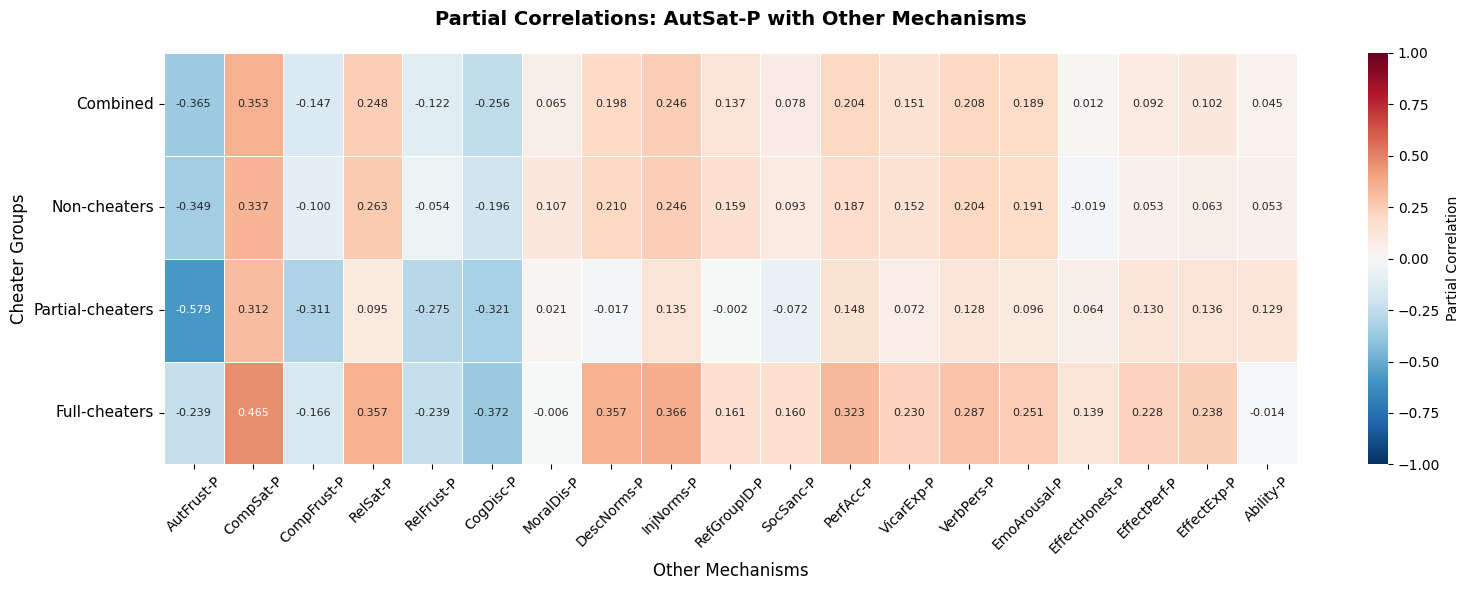

Creating heatmap 2/20: AutFrust-P


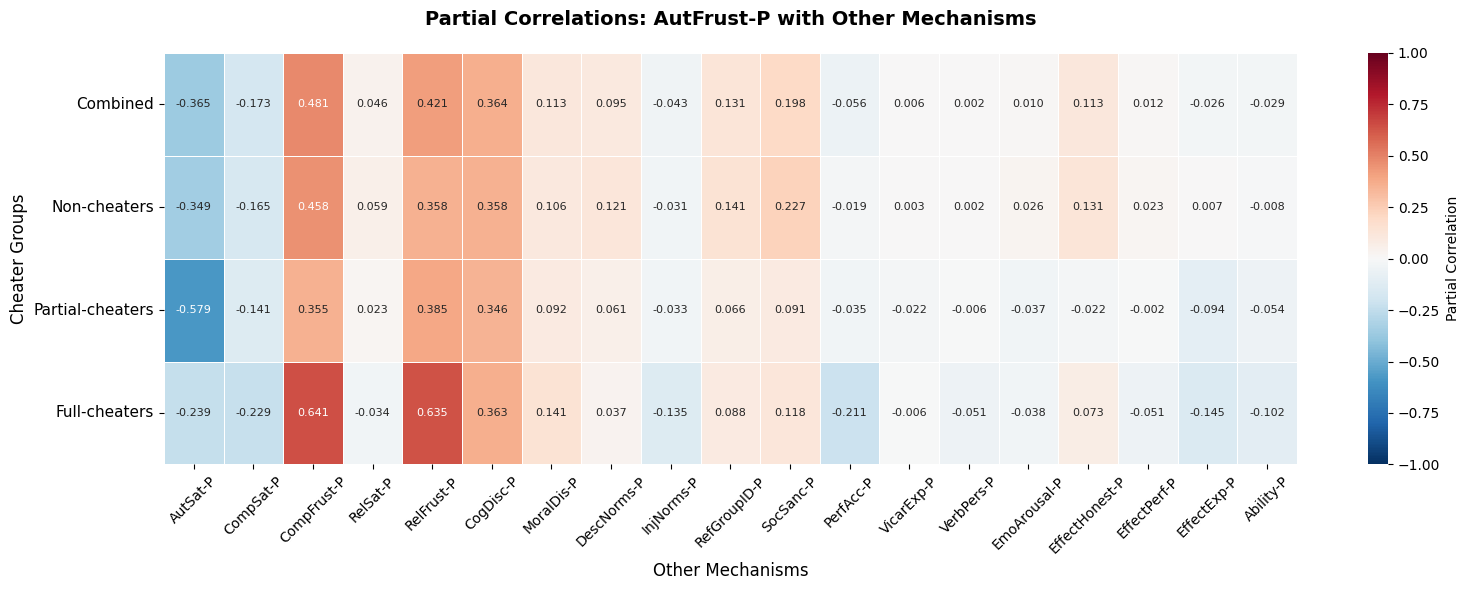

Creating heatmap 3/20: CompSat-P


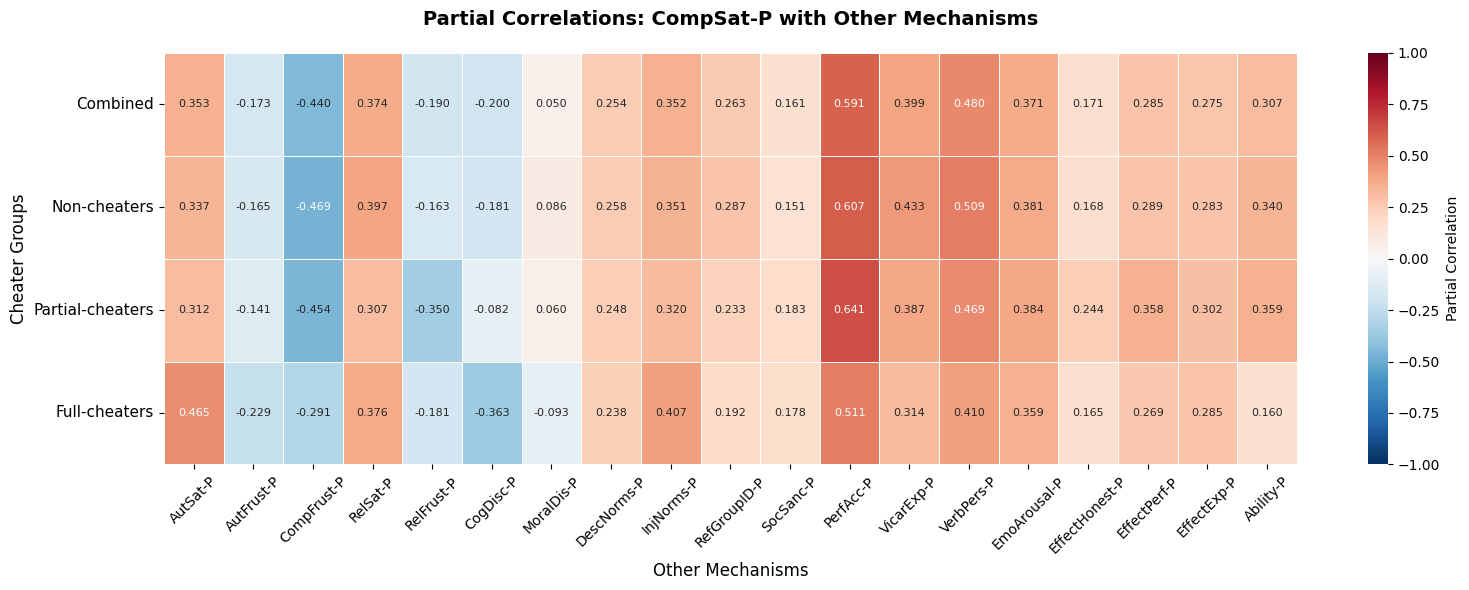

Creating heatmap 4/20: CompFrust-P


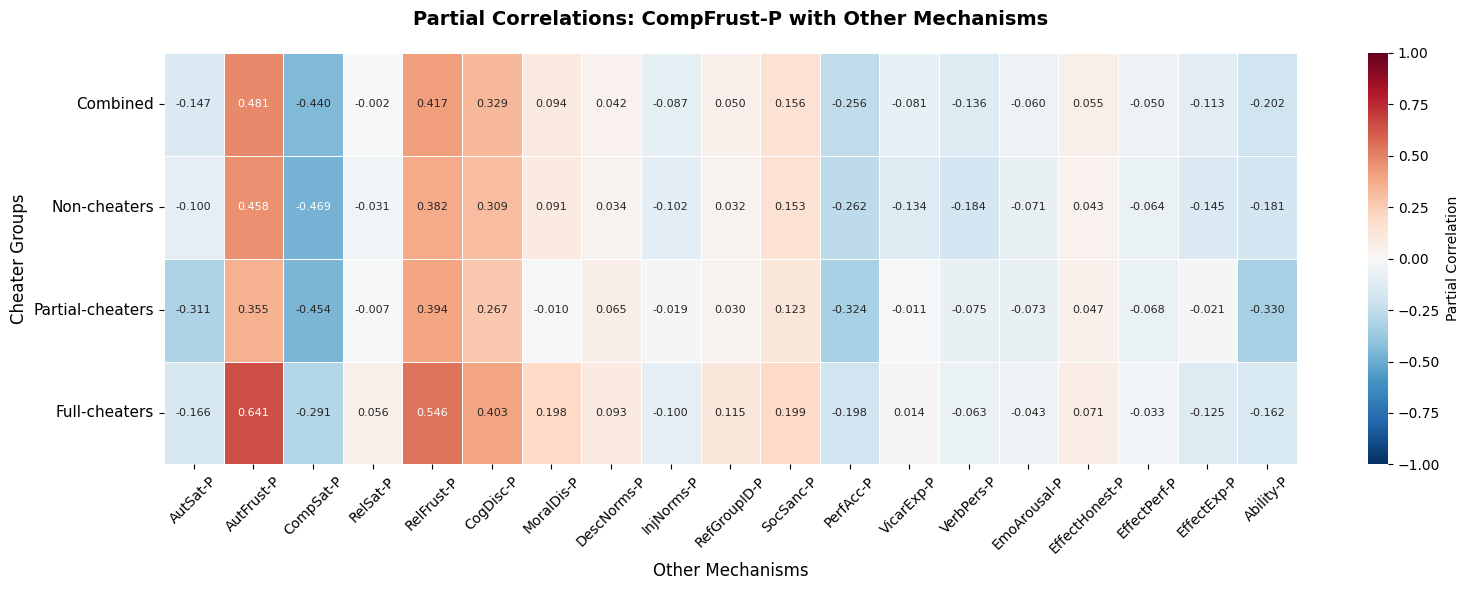

Creating heatmap 5/20: RelSat-P


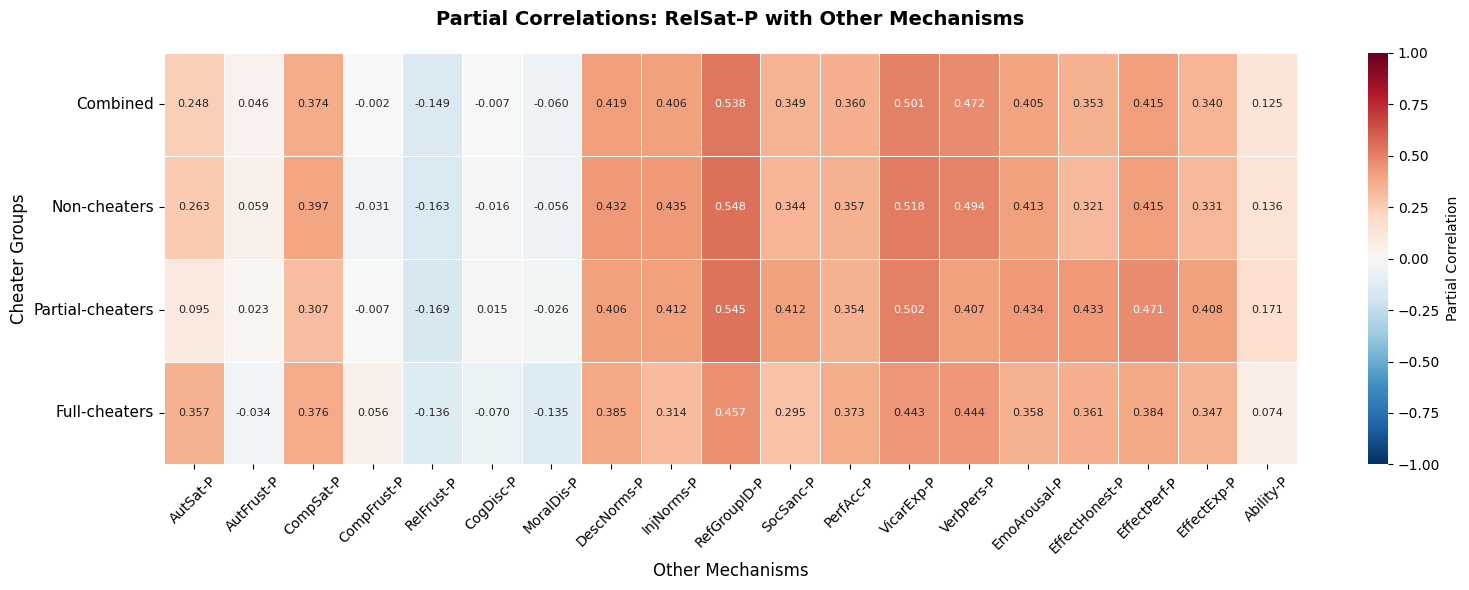

Creating heatmap 6/20: RelFrust-P


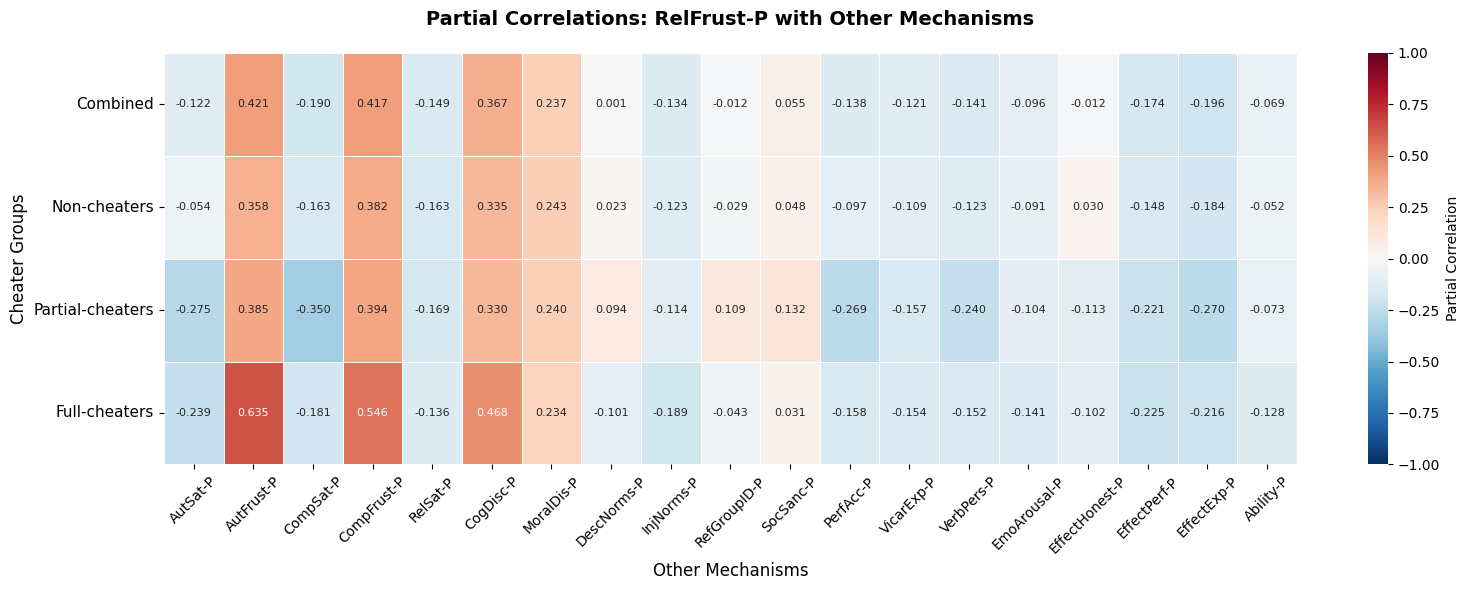

Creating heatmap 7/20: CogDisc-P


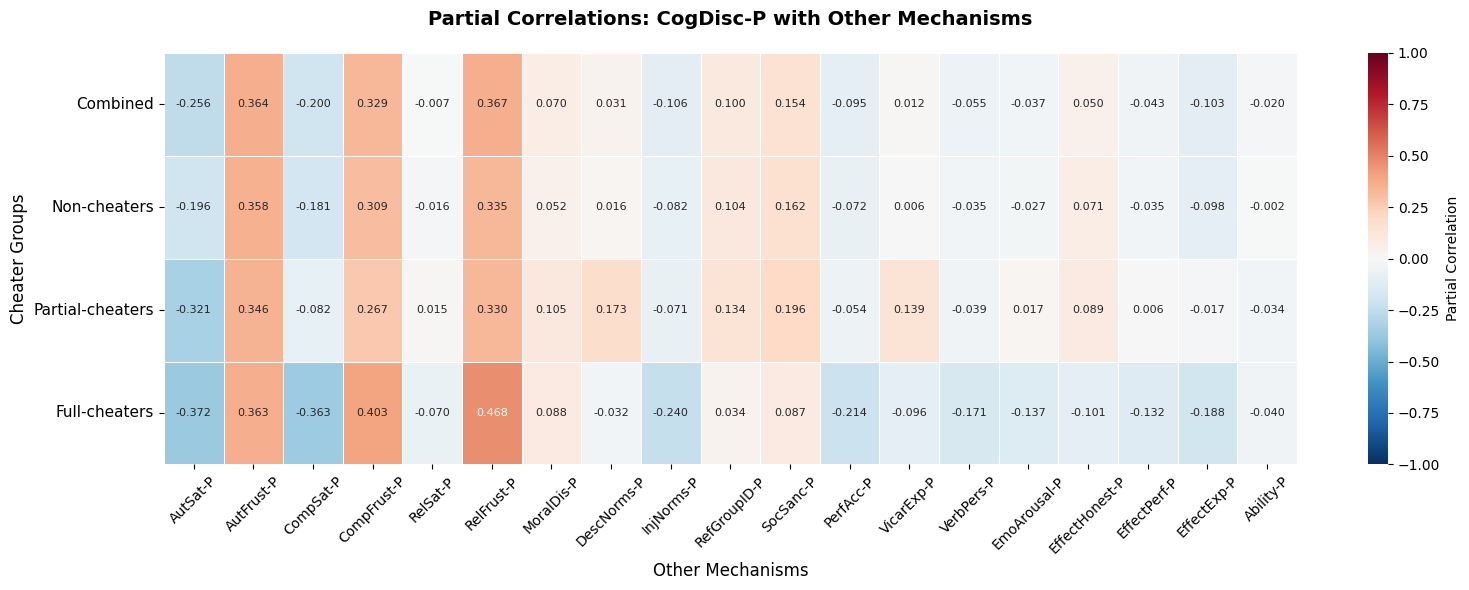

Creating heatmap 8/20: MoralDis-P


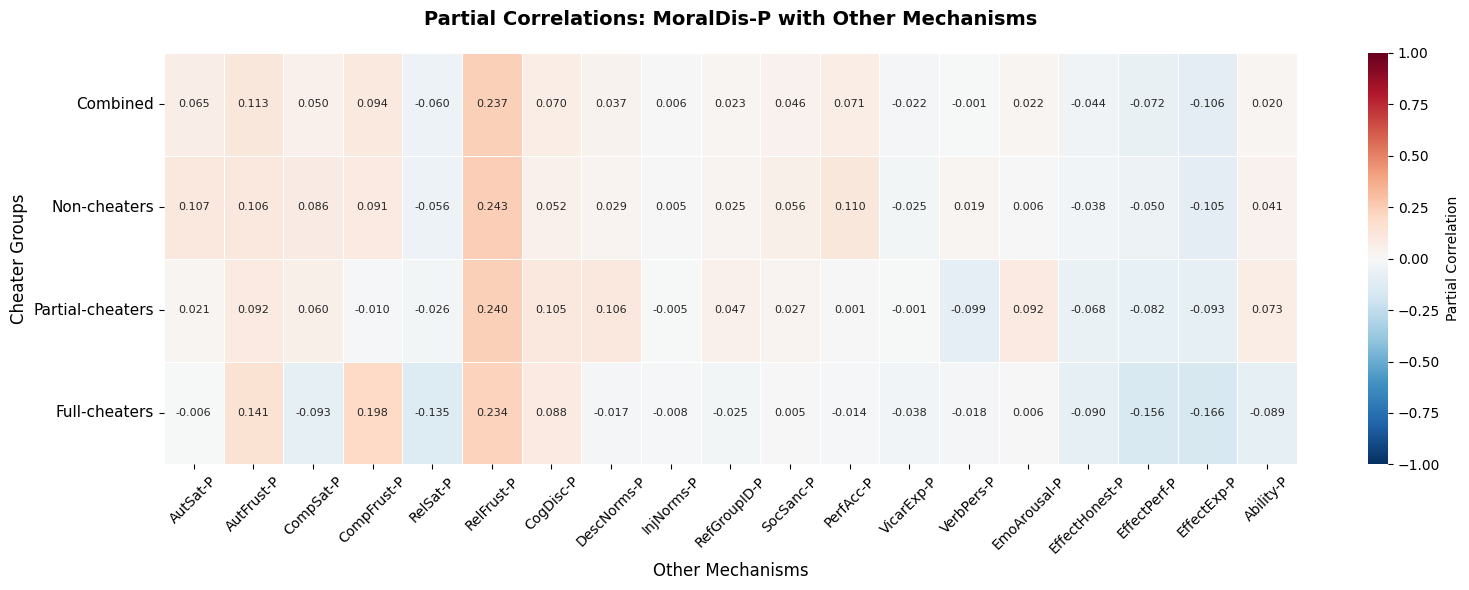

Creating heatmap 9/20: DescNorms-P


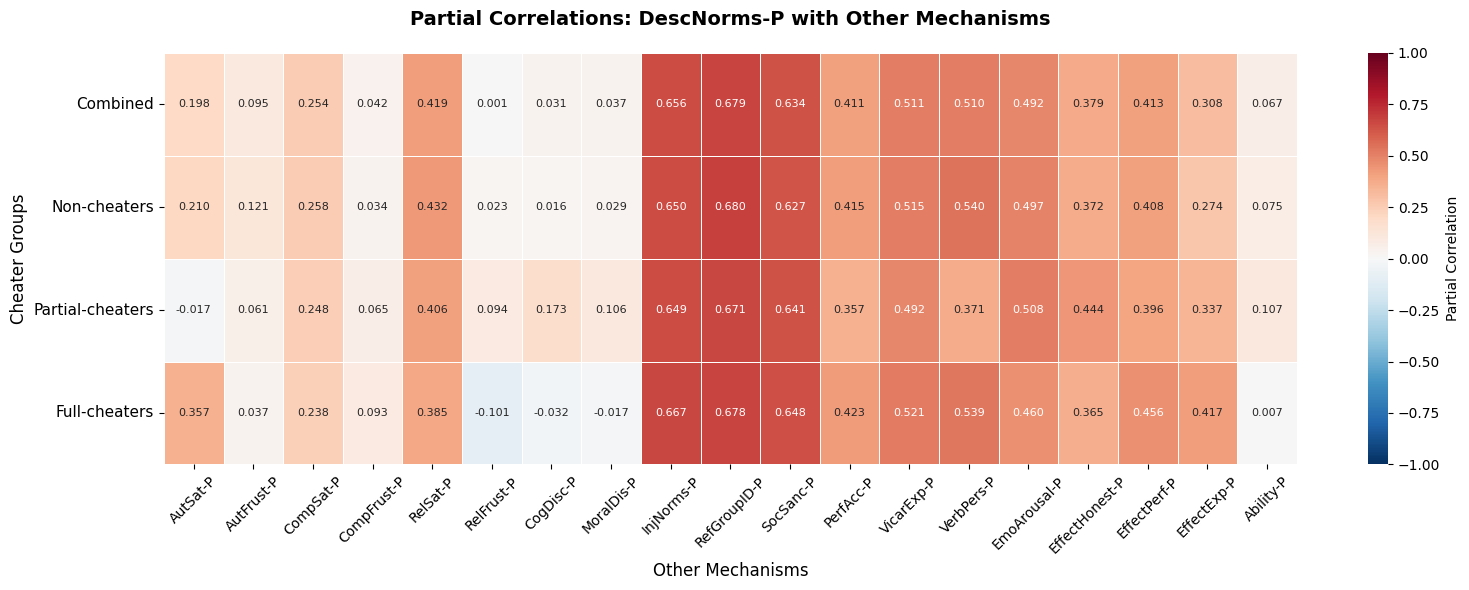

Creating heatmap 10/20: InjNorms-P


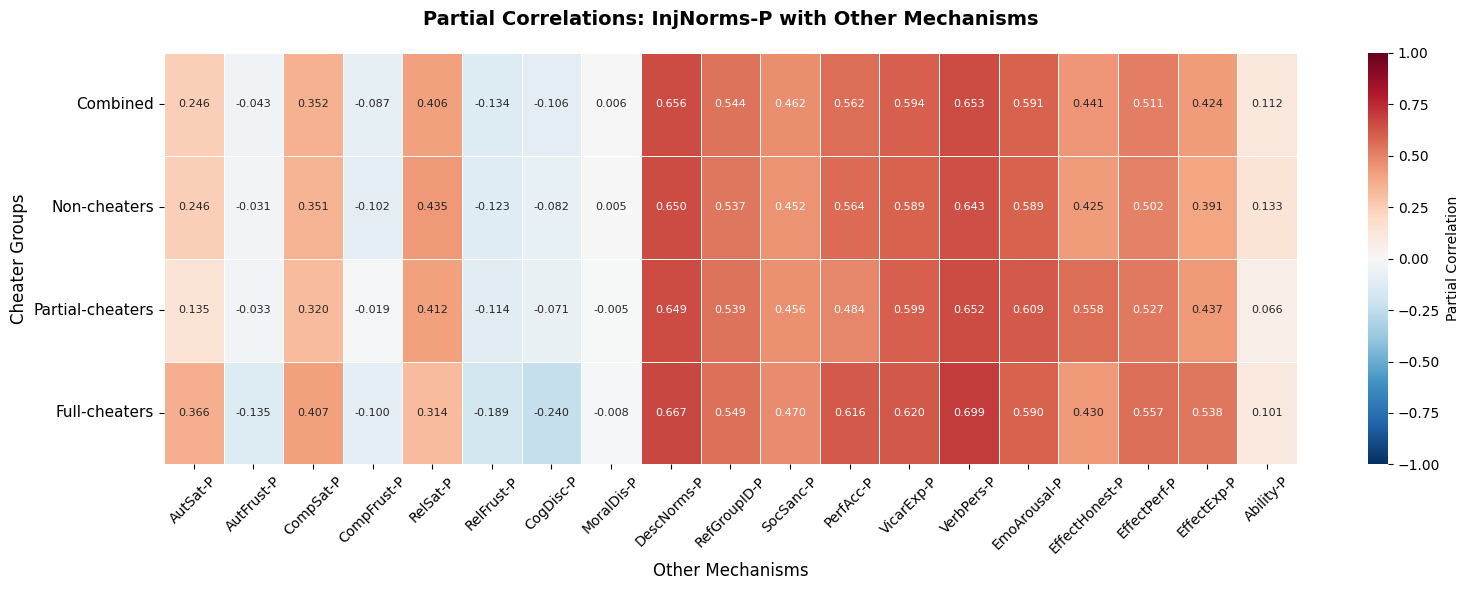

Creating heatmap 11/20: RefGroupID-P


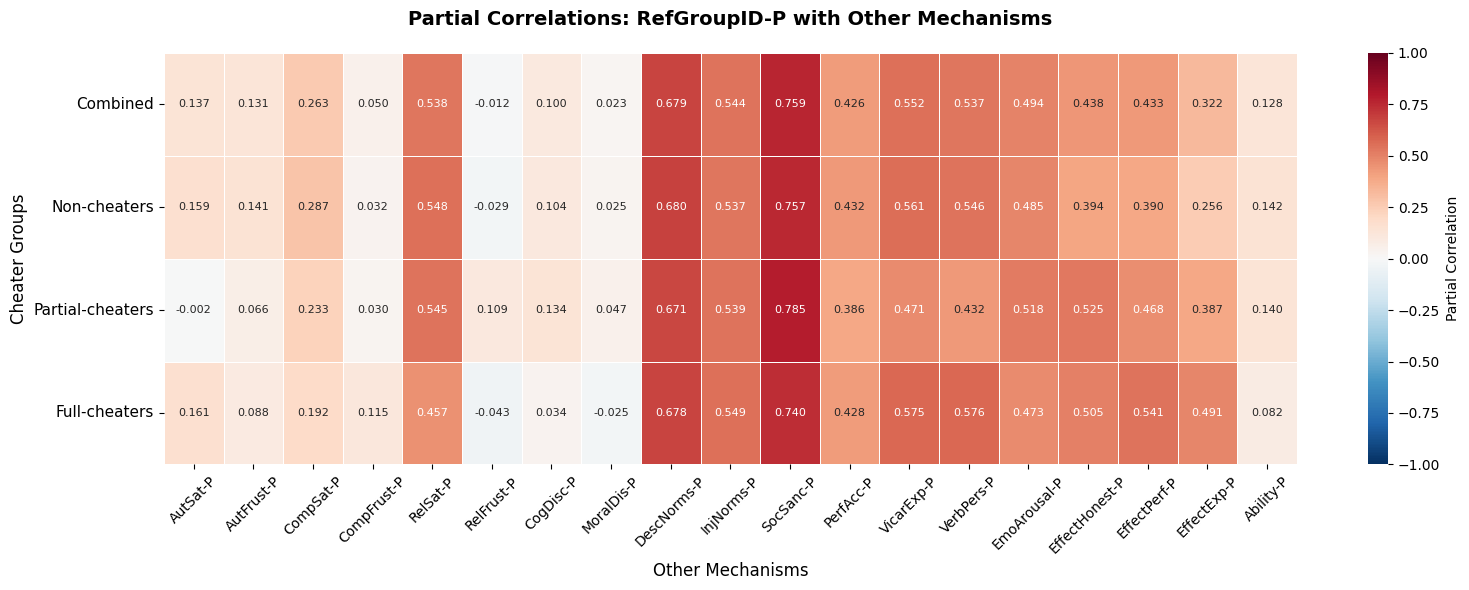

Creating heatmap 12/20: SocSanc-P


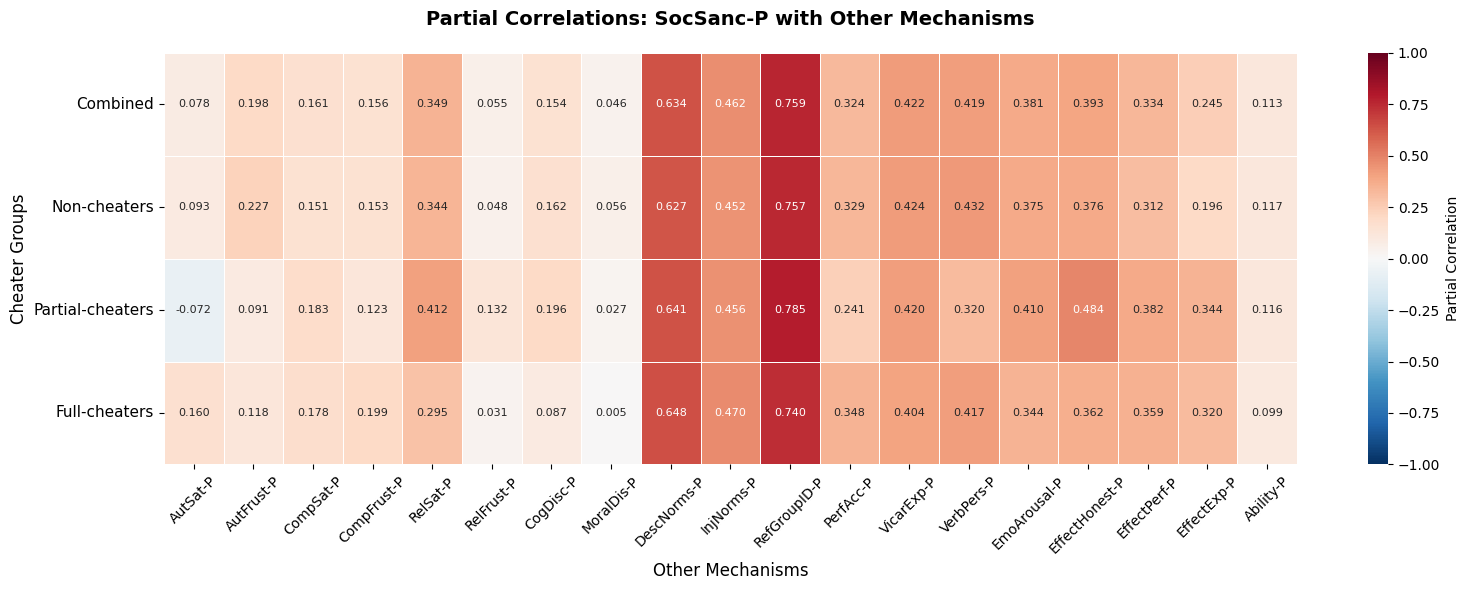

Creating heatmap 13/20: PerfAcc-P


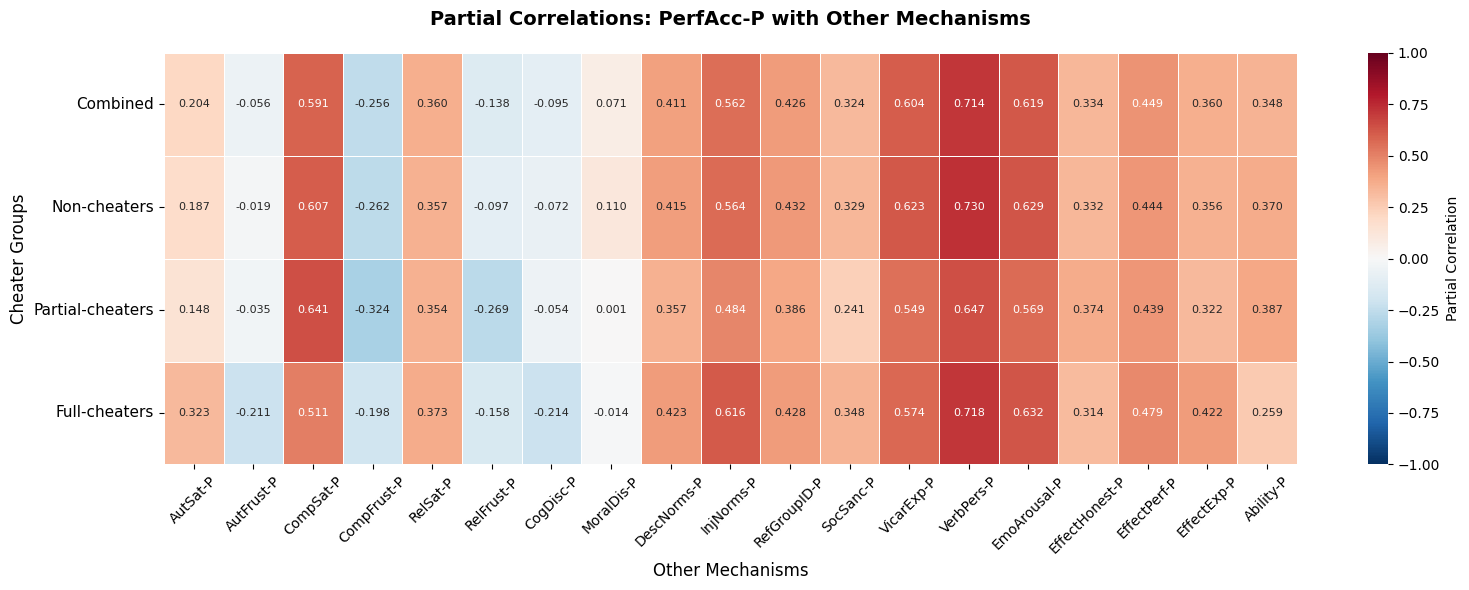

Creating heatmap 14/20: VicarExp-P


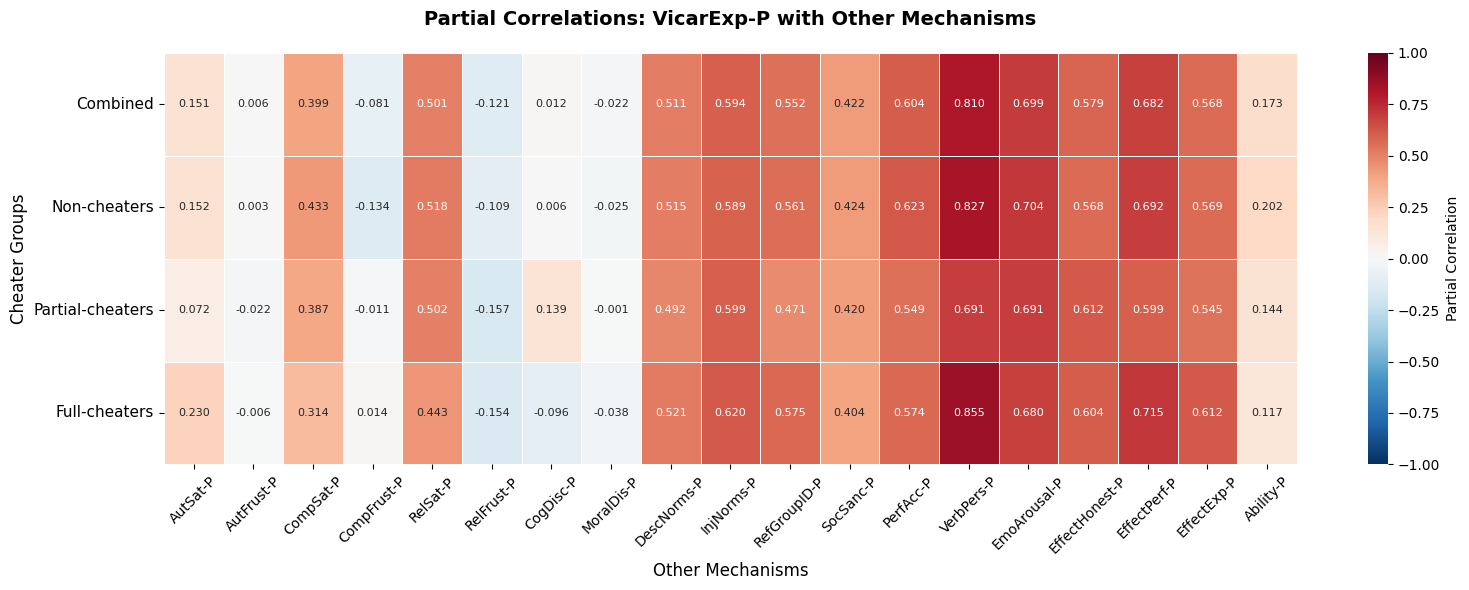

Creating heatmap 15/20: VerbPers-P


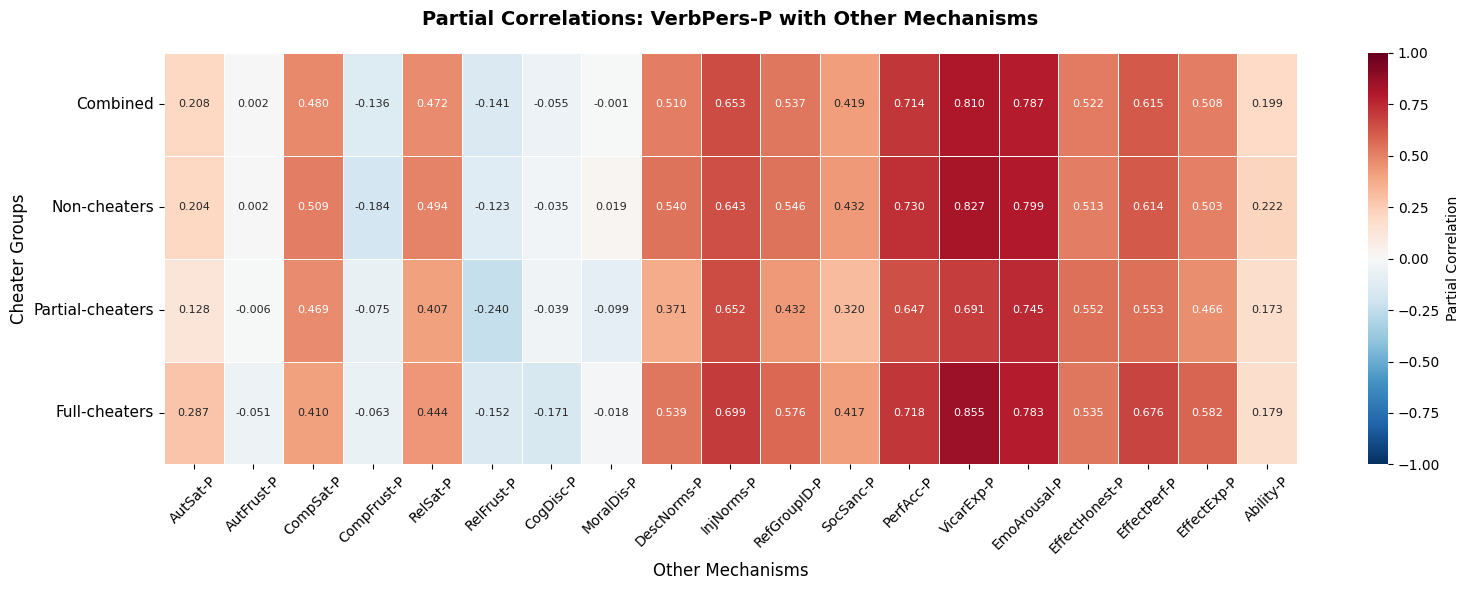

Creating heatmap 16/20: EmoArousal-P


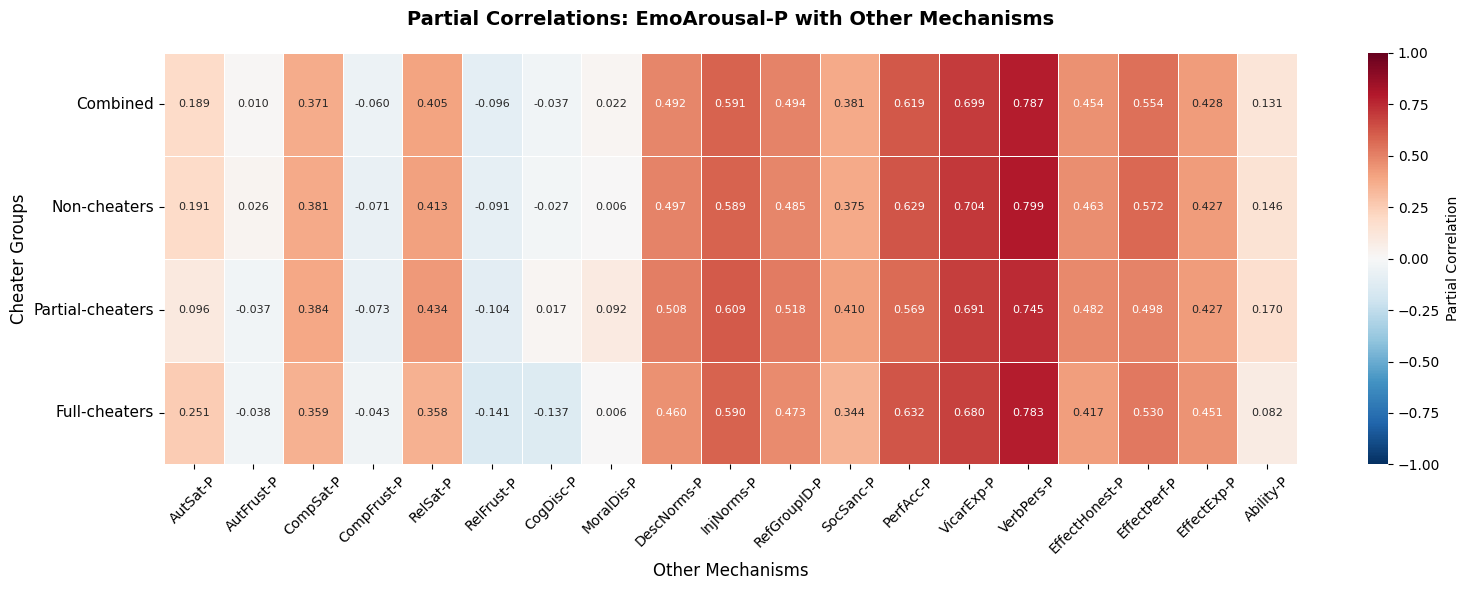

Creating heatmap 17/20: EffectHonest-P


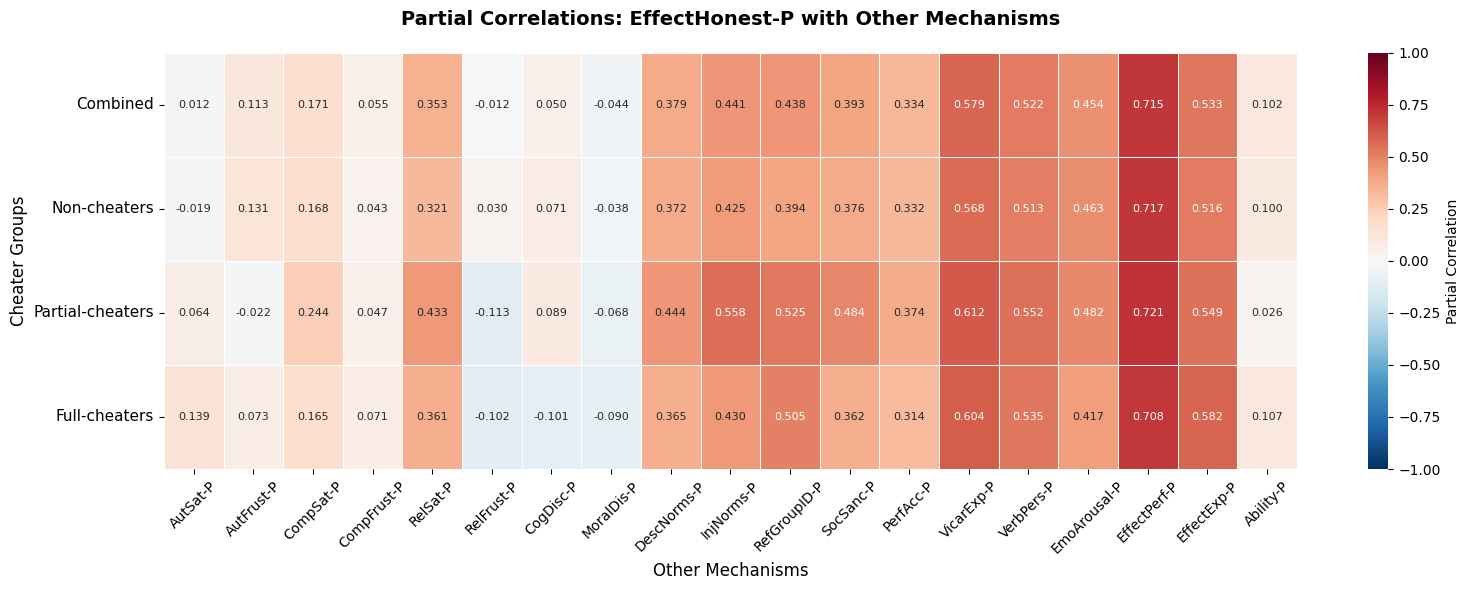

Creating heatmap 18/20: EffectPerf-P


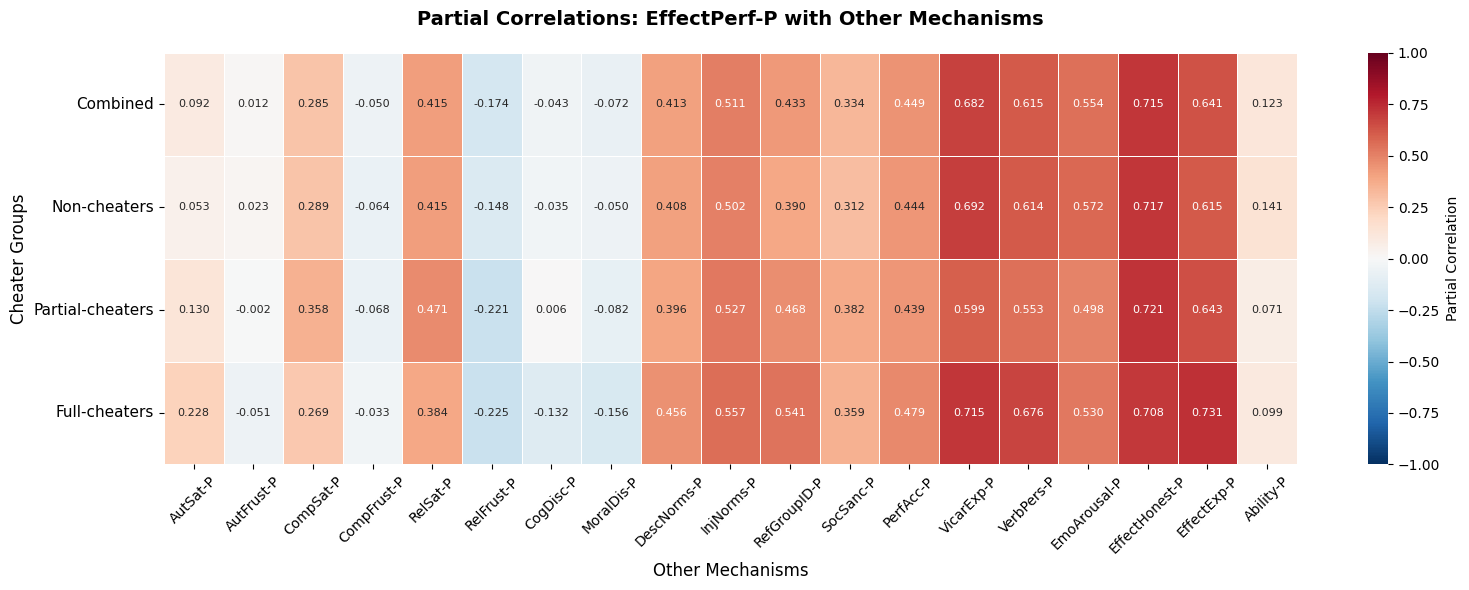

Creating heatmap 19/20: EffectExp-P


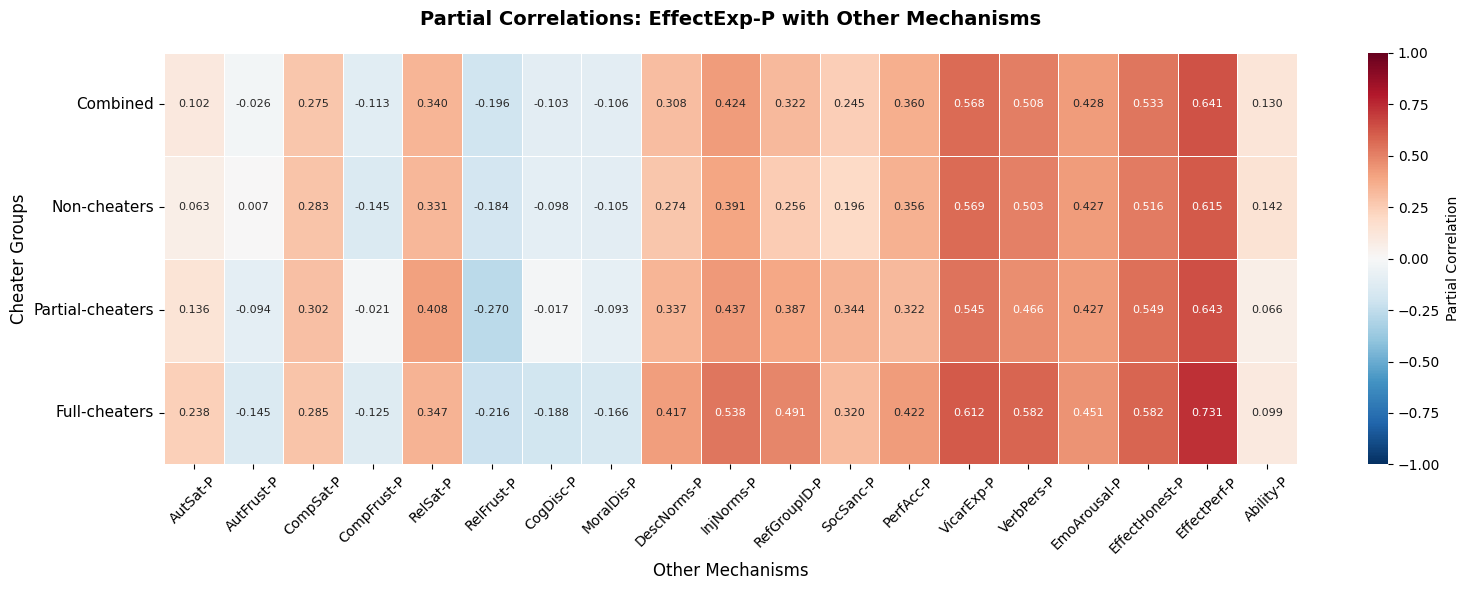

Creating heatmap 20/20: Ability-P


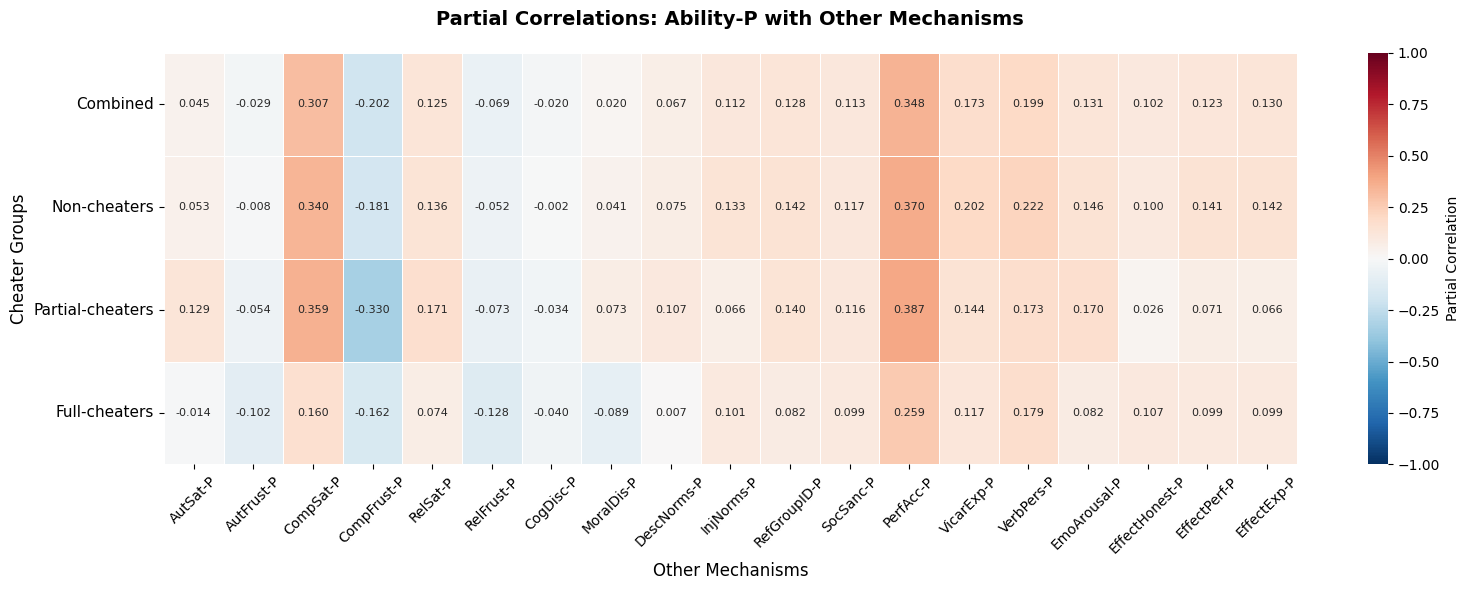


All heatmaps generated successfully!
Files saved as: heatmap_[mechanism_name].png


In [ ]:
# =============================================================================
# 4. MECHANISM-TO-MECHANISM HEATMAPS FOR ALL CHEATER GROUPS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Load network data (reusing from earlier cells)
df_combined = pd.read_csv('network_edges_intervention.csv')
df_groups = pd.read_csv('cheater_group_networks_intervention.csv')

# Define mechanisms (reusing from earlier)
mechanisms = ['AutSat-P', 'AutFrust-P', 'CompSat-P', 'CompFrust-P', 'RelSat-P', 
             'RelFrust-P', 'CogDisc-P', 'MoralDis-P', 'DescNorms-P', 'InjNorms-P', 
             'RefGroupID-P', 'SocSanc-P', 'PerfAcc-P', 'VicarExp-P', 'VerbPers-P', 
             'EmoArousal-P', 'EffectHonest-P', 'EffectPerf-P', 'EffectExp-P', 'Ability-P']

# Create combined dataframe with all groups
df_combined['cheater_group'] = 'combined'
df_all = pd.concat([df_combined, df_groups], ignore_index=True)

# Filter mechanism-to-mechanism edges only
mech_edges = df_all[
    df_all['source'].isin(mechanisms) & 
    df_all['target'].isin(mechanisms)
].copy()

# Create correlation matrices for each group
groups = ['combined', 'non_cheaters', 'partial_cheaters', 'full_cheaters']
group_labels = ['Combined', 'Non-cheaters', 'Partial-cheaters', 'Full-cheaters']

def create_correlation_matrix(edges_df, group):
    """Create correlation matrix for a specific group"""
    group_data = edges_df[edges_df['cheater_group'] == group]
    
    # Initialize matrix with NaN
    matrix = pd.DataFrame(index=mechanisms, columns=mechanisms, dtype=float)
    matrix.values[np.diag_indices_from(matrix)] = 1.0  # Diagonal = 1
    
    # Fill in correlations (both directions since correlation is symmetric)
    for _, row in group_data.iterrows():
        if row['source'] in mechanisms and row['target'] in mechanisms:
            matrix.loc[row['source'], row['target']] = row['partial_correlation']
            matrix.loc[row['target'], row['source']] = row['partial_correlation']
    
    return matrix

# Generate all correlation matrices
corr_matrices = {group: create_correlation_matrix(mech_edges, group) for group in groups}

def create_mechanism_heatmap(focal_mechanism, save_fig=False):
    """Create heatmap for one focal mechanism across all groups"""
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Extract data for focal mechanism across groups
    other_mechs = [m for m in mechanisms if m != focal_mechanism]
    heatmap_data = []
    
    for group, label in zip(groups, group_labels):
        row_data = []
        for other_mech in other_mechs:
            corr = corr_matrices[group].loc[focal_mechanism, other_mech]
            row_data.append(corr if not pd.isna(corr) else 0)
        heatmap_data.append(row_data)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=group_labels, columns=other_mechs)
    
    # Create heatmap
    sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, cbar_kws={'label': 'Partial Correlation'},
                linewidths=0.5, ax=ax, annot_kws={'size': 8})
    
    ax.set_title(f'Partial Correlations: {focal_mechanism} with Other Mechanisms',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Other Mechanisms', fontsize=12)
    ax.set_ylabel('Cheater Groups', fontsize=12)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', rotation=0, labelsize=11)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f'heatmap_{focal_mechanism.replace("-", "_")}.png', 
                   dpi=300, bbox_inches='tight')
    
    plt.show()
    return heatmap_df

# Generate all 20 heatmaps
print("Generating 20 mechanism heatmaps...")
print("="*60)

for i, mechanism in enumerate(mechanisms, 1):
    print(f"Creating heatmap {i}/20: {mechanism}")
    create_mechanism_heatmap(mechanism)

print("\nAll heatmaps generated successfully!")

In [5]:
# =============================================================================
# 3. PRODUCE CSV WITH ALL EDGES BETWEEN CONCEPTS, MECHANISMS AND OUTCOMES
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from itertools import combinations

# Load and prepare data
df = pd.read_csv('../data/final_dataset.csv')

concepts = ['performance_accomplishments', 'emotional_arousal', 'dissonance_arousal',
           'reference_group_identification', 'relatedness', 'social_sanctions', 
           'autonomy', 'competence', 'cognitive_inconsistency', 'self_concept',
           'vicarious_experience', 'dissonance_reduction', 'injunctive_norms',
           'verbal_persuasion', 'descriptive_norms']

mechanisms = ['autonomy_need_satisfaction', 'autonomy_need_frustration',
             'competence_need_satisfaction', 'competence_need_frustration',
             'relatedness_need_satisfaction', 'relatedness_need_frustration',
             'cognitive_discomfort', 'moral_disengagement', 'descriptive_norms',
             'injunctive_norms', 'reference_group_identification', 'social_sanctions',
             'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion',
             'emotional_arousal', 'PME_on_honest_task_completion', 'PME_on_task_performance',
             'PME_on_task_experience', 'word_creation_skill_level']

# Concept name mappings
concept_names = {
    'performance_accomplishments': 'PerfAcc', 'emotional_arousal': 'EmoArousal',
    'dissonance_arousal': 'DissArousal', 'reference_group_identification': 'RefGroupID',
    'relatedness': 'Related', 'social_sanctions': 'SocSanc', 'autonomy': 'Autonomy',
    'competence': 'Comp', 'cognitive_inconsistency': 'CogIncon', 'self_concept': 'SelfCon',
    'vicarious_experience': 'VicarExp', 'dissonance_reduction': 'DissReduc',
    'injunctive_norms': 'InjNorms', 'verbal_persuasion': 'VerbPers', 'descriptive_norms': 'DescNorms'
}

# Mechanism name mappings  
mechanism_names = {
    'autonomy_need_satisfaction': 'AutSat-P', 'autonomy_need_frustration': 'AutFrust-P',
    'competence_need_satisfaction': 'CompSat-P', 'competence_need_frustration': 'CompFrust-P',
    'relatedness_need_satisfaction': 'RelSat-P', 'relatedness_need_frustration': 'RelFrust-P',
    'cognitive_discomfort': 'CogDisc-P', 'moral_disengagement': 'MoralDis-P',
    'descriptive_norms': 'DescNorms-P', 'injunctive_norms': 'InjNorms-P',
    'reference_group_identification': 'RefGroupID-P', 'social_sanctions': 'SocSanc-P',
    'performance_accomplishments': 'PerfAcc-P', 'vicarious_experience': 'VicarExp-P',
    'verbal_persuasion': 'VerbPers-P', 'emotional_arousal': 'EmoArousal-P',
    'PME_on_honest_task_completion': 'EffectHonest-P', 'PME_on_task_performance': 'EffectPerf-P',
    'PME_on_task_experience': 'EffectExp-P', 'word_creation_skill_level': 'Ability-P'
}


# Create concept dummy variables
for concept in concepts:
    df[f'concept_{concept}'] = (df['concept'] == concept).astype(int)

# Create outcomes
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(
    lambda x: 0 if x == 0 else (2 if x == 1 else 1)
)
df['performance'] = df['performance_score_including_cheated_words']
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2

# Clean data
concept_vars = [f'concept_{c}' for c in concepts]
outcome_vars = ['cheating_behavior', 'performance', 'experience']
all_vars = concept_vars + mechanisms + outcome_vars
df_clean = df.dropna(subset=all_vars)

# Standardize continuous variables
scaler = StandardScaler()
df_clean[mechanisms + ['performance', 'experience']] = scaler.fit_transform(
    df_clean[mechanisms + ['performance', 'experience']]
)

def partial_correlation(x, y, controls):
    """Calculate partial correlation controlling for other variables"""
    reg_x = LinearRegression().fit(controls, x)
    reg_y = LinearRegression().fit(controls, y)
    res_x = x - reg_x.predict(controls)
    res_y = y - reg_y.predict(controls)
    return np.corrcoef(res_x, res_y)[0, 1]

# Prepare data matrix
X_all = df_clean[all_vars].values
edges = []

print(f"Sample size: {len(df_clean)}")

# 1. Concept-Mechanism edges (300)
for i, concept in enumerate(concepts):
    for j, mechanism in enumerate(mechanisms):
        mask = np.ones(len(all_vars), dtype=bool)
        mask[i] = False  # exclude concept
        mask[len(concepts) + j] = False  # exclude mechanism
        
        try:
            pcorr = partial_correlation(
                X_all[:, i], 
                X_all[:, len(concepts) + j], 
                X_all[:, mask]
            )
            if not np.isnan(pcorr):
                edges.append({
                    'source': concept_names[concept],
                    'target': mechanism_names[mechanism],
                    'partial_correlation': pcorr,
                    'edge_type': 'concept_to_mechanism'
                })
        except:
            continue

# 2. Mechanism-Mechanism edges (190)  
for i, j in combinations(range(len(mechanisms)), 2):
    controls_idx = list(range(len(concepts))) + list(range(len(concepts) + len(mechanisms), len(all_vars)))
    
    try:
        pcorr = partial_correlation(
            X_all[:, len(concepts) + i],
            X_all[:, len(concepts) + j], 
            X_all[:, controls_idx]
        )
        if not np.isnan(pcorr):
            edges.append({
                'source': mechanism_names[mechanisms[i]],
                'target': mechanism_names[mechanisms[j]],
                'partial_correlation': pcorr,
                'edge_type': 'mechanism_to_mechanism'
            })
    except:
        continue

# 3. Mechanism-Outcome edges (60)
for i, mechanism in enumerate(mechanisms):
    for j, outcome in enumerate(outcome_vars):
        # Control for concepts and other mechanisms
        controls_idx = (list(range(len(concepts))) + 
                       [len(concepts) + k for k in range(len(mechanisms)) if k != i])
        
        try:
            pcorr = partial_correlation(
                X_all[:, len(concepts) + i],
                X_all[:, len(concepts) + len(mechanisms) + j],
                X_all[:, controls_idx]
            )
            if not np.isnan(pcorr):
                edges.append({
                    'source': mechanism_names[mechanism],
                    'target': outcome,
                    'partial_correlation': pcorr,
                    'edge_type': 'mechanism_to_outcome'
                })
        except:
            continue

# 4. Outcome-Outcome edges (3)
for i, j in combinations(range(len(outcome_vars)), 2):
    # Control for concepts and mechanisms
    controls_idx = list(range(len(concepts) + len(mechanisms)))
    
    try:
        pcorr = partial_correlation(
            X_all[:, len(concepts) + len(mechanisms) + i],
            X_all[:, len(concepts) + len(mechanisms) + j],
            X_all[:, controls_idx]
        )
        if not np.isnan(pcorr):
            edges.append({
                'source': outcome_vars[i],
                'target': outcome_vars[j],
                'partial_correlation': pcorr,
                'edge_type': 'outcome_to_outcome'
            })
    except:
        continue

# Create and save network
network_df = pd.DataFrame(edges)
network_df.to_csv('network_edges.csv', index=False)

print(f"Total edges: {len(network_df)}")
print(network_df['edge_type'].value_counts())


Sample size: 1232
Total edges: 553
edge_type
concept_to_mechanism      300
mechanism_to_mechanism    190
mechanism_to_outcome       60
outcome_to_outcome          3
Name: count, dtype: int64


In [ ]:
# =============================================================================
# 4. SIMPLIFIED NETWORK ANALYSIS: TOP PARTIAL CORRELATIONS BY NODE TYPES
# =============================================================================

import pandas as pd
import numpy as np

# Load the network data
df = pd.read_csv('network_edges.csv')

# First, let's identify perceived outcomes that are mislabeled as mechanism_to_outcome
perceived_outcomes = ['EffectHonest-P', 'EffectPerf-P', 'EffectExp-P']
actual_outcomes = ['cheating_behavior', 'performance', 'experience']

# Fix the edge type classification
def fix_edge_type(row):
    """Fix edge types to properly classify perceived outcomes"""
    if row['edge_type'] == 'mechanism_to_outcome':
        if row['source'] in perceived_outcomes:
            return 'perceived_to_actual'
        else:
            return 'mechanism_to_outcome'
    return row['edge_type']

df['corrected_edge_type'] = df.apply(fix_edge_type, axis=1)

print("="*80)
print("NETWORK ANALYSIS: TOP PARTIAL CORRELATIONS BY NODE TYPES")
print("="*80)
print("Note: All correlations are PARTIAL correlations (controlling for other variables)")
print("="*80)

# Define node categories for classification
concept_nodes = ['PerfAcc', 'EmoArousal', 'DissArousal', 'RefGroupID', 'Related', 
                'SocSanc', 'Autonomy', 'Comp', 'CogIncon', 'SelfCon', 'VicarExp', 
                'DissReduc', 'InjNorms', 'VerbPers', 'DescNorms']

mechanism_nodes = ['AutSat-P', 'AutFrust-P', 'CompSat-P', 'CompFrust-P', 'RelSat-P', 
                  'RelFrust-P', 'CogDisc-P', 'MoralDis-P', 'DescNorms-P', 'InjNorms-P', 
                  'RefGroupID-P', 'SocSanc-P', 'PerfAcc-P', 'VicarExp-P', 'VerbPers-P', 
                  'EmoArousal-P', 'Ability-P']

perceived_outcomes = ['EffectHonest-P', 'EffectPerf-P', 'EffectExp-P']

actual_outcome_nodes = ['cheating_behavior', 'performance', 'experience']

def classify_node(node):
    """Classify a node into its category"""
    if node in concept_nodes:
        return 'Concept'
    elif node in perceived_outcomes:
        return 'Perceived_Outcomes'
    elif node in mechanism_nodes:
        return 'Mechanism'
    elif node in actual_outcome_nodes:
        return 'Actual_Outcomes'
    else:
        return 'Unknown'

def get_edge_type_simple(source, target):
    """Get simplified edge type classification"""
    source_type = classify_node(source)
    target_type = classify_node(target)
    
    # Create consistent naming regardless of direction
    types = sorted([source_type, target_type])
    return f"{types[0]} ↔ {types[1]}"

# Classify all edges and get absolute correlations
df['source_type'] = df['source'].apply(classify_node)
df['target_type'] = df['target'].apply(classify_node)
df['simple_edge_type'] = df.apply(lambda row: get_edge_type_simple(row['source'], row['target']), axis=1)
df['abs_correlation'] = df['partial_correlation'].abs()

# Override simple_edge_type for perceived-to-actual relationships
perceived_to_actual_mask = (df['source'].isin(perceived_outcomes)) & (df['target'].isin(actual_outcomes))
df.loc[perceived_to_actual_mask, 'simple_edge_type'] = 'Perceived_Outcomes ↔ Actual_Outcomes'

# Define the order we want to display results
ordered_edge_types = [
    'Concept ↔ Mechanism',
    'Concept ↔ Perceived_Outcomes', 
    'Concept ↔ Actual_Outcomes',
    'Mechanism ↔ Mechanism',
    'Mechanism ↔ Perceived_Outcomes',
    'Mechanism ↔ Actual_Outcomes',
    'Perceived_Outcomes ↔ Perceived_Outcomes',
    'Perceived_Outcomes ↔ Actual_Outcomes',
    'Actual_Outcomes ↔ Actual_Outcomes'
]

# Get available edge types from data
available_edge_types = df['simple_edge_type'].unique()

# Filter to only include edge types that exist in data and maintain our preferred order
edge_types_to_show = [et for et in ordered_edge_types if et in available_edge_types]

print(f"Total edges analyzed: {len(df)}")
print(f"Edge type categories: {len(edge_types_to_show)}")
print()

# Show top 10 correlations for each edge type in our preferred order
for edge_type in edge_types_to_show:
    subset = df[df['simple_edge_type'] == edge_type].copy()
    
    if len(subset) == 0:
        continue
    
    # Sort by absolute correlation and get top 10
    top_correlations = subset.nlargest(10, 'abs_correlation')
    
    print(f"\n{edge_type.upper()}")
    print("-" * 60)
    print(f"Total edges: {len(subset)}")
    
    # Add framework analysis for mechanism-mechanism edges
    if edge_type == 'Mechanism ↔ Mechanism':
        # Define theory frameworks
        frameworks = {
            'Self-Determination': ['AutSat-P', 'AutFrust-P', 'CompSat-P', 'CompFrust-P', 'RelSat-P', 'RelFrust-P'],
            'Cognitive-Dissonance': ['CogDisc-P', 'MoralDis-P'],
            'Self-Efficacy': ['PerfAcc-P', 'VicarExp-P', 'VerbPers-P', 'EmoArousal-P'],
            'Social-Norms': ['DescNorms-P', 'InjNorms-P', 'RefGroupID-P', 'SocSanc-P'],
            'Perceived_Outcomes': ['EffectHonest-P', 'EffectPerf-P', 'EffectExp-P'],
            'Individual': ['Ability-P']
        }
        
        # Create mechanism to theory mapping
        mech_to_theory = {}
        for theory, mechs in frameworks.items():
            for mech in mechs:
                mech_to_theory[mech] = theory
        
        # Classify as within or cross-framework
        subset['source_theory'] = subset['source'].map(mech_to_theory)
        subset['target_theory'] = subset['target'].map(mech_to_theory)
        subset['framework_type'] = subset.apply(
            lambda row: 'Within-Framework' if row['source_theory'] == row['target_theory'] else 'Cross-Framework', 
            axis=1
        )
        
        within_count = (subset['framework_type'] == 'Within-Framework').sum()
        cross_count = (subset['framework_type'] == 'Cross-Framework').sum()
        
        print(f"Within-framework: {within_count} edges")
        print(f"Cross-framework: {cross_count} edges")
    
    # print("\nTop 10 partial correlations:")
    
    for i, (idx, row) in enumerate(top_correlations.iterrows()):
        # Show correlation with sign
        corr_str = f"{row['partial_correlation']:+.3f}"
        framework_info = ""
        if edge_type == 'Mechanism ↔ Mechanism' and 'source_theory' in row:
            if row['framework_type'] == 'Within-Framework':
                framework_info = f" ({row['source_theory']})"
            else:
                framework_info = f" ({row['source_theory']} × {row['target_theory']})"
        print(f"  {row['source']} ↔ {row['target']}: {corr_str}{framework_info}")
    
    # Show framework breakdown for mechanism-mechanism edges
    if edge_type == 'Mechanism ↔ Mechanism':
        print(f"\nTop 10 within-framework correlations:")
        within_fw = subset[subset['framework_type'] == 'Within-Framework']
        if len(within_fw) > 0:
            top_within = within_fw.nlargest(10, 'abs_correlation')
            for idx, row in top_within.iterrows():
                corr_str = f"{row['partial_correlation']:+.3f}"
                print(f"  {row['source']} ↔ {row['target']}: {corr_str} ({row['source_theory']})")
        
        print(f"\nTop 10 cross-framework correlations:")
        cross_fw = subset[subset['framework_type'] == 'Cross-Framework']
        if len(cross_fw) > 0:
            top_cross = cross_fw.nlargest(10, 'abs_correlation')
            for idx, row in top_cross.iterrows():
                corr_str = f"{row['partial_correlation']:+.3f}"
                print(f"  {row['source']} ({row['source_theory']}) ↔ {row['target']} ({row['target_theory']}): {corr_str}")

# =============================================================================
# STRONGEST OVERALL PARTIAL CORRELATIONS (ACROSS ALL TYPES)
# =============================================================================

print("\n" + "="*80)
print("TOP 20 STRONGEST PARTIAL CORRELATIONS (ALL EDGE TYPES)")
print("="*80)

top_overall = df.nlargest(20, 'abs_correlation')
for idx, row in top_overall.iterrows():
    corr_str = f"{row['partial_correlation']:+.3f}"
    print(f"{row['source']} ↔ {row['target']}: {corr_str} ({row['simple_edge_type']})")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("Notes:")
print("- All correlations are partial correlations controlling for other network variables")
print("- Framework analysis integrated into Mechanism ↔ Mechanism section")

In [6]:
# =============================================================================
# 5. CHEATER GROUP-SPECIFIC NETWORK ANALYSIS
# =============================================================================

import pandas as pd
import numpy as np

# Load the cheater group network data
df_net = pd.read_csv('cheater_group_networks.csv')

print("\n" + "="*80)
print("CHEATER GROUP-SPECIFIC NETWORK ANALYSIS")
print("="*80)
print("Note: All correlations are PARTIAL correlations (controlling for other variables)")
print("="*80)

# Define node categories for classification (same as main analysis)
concept_nodes = ['PerfAcc', 'EmoArousal', 'DissArousal', 'RefGroupID', 'Related', 
                'SocSanc', 'Autonomy', 'Comp', 'CogIncon', 'SelfCon', 'VicarExp', 
                'DissReduc', 'InjNorms', 'VerbPers', 'DescNorms']

mechanism_nodes = ['AutSat-P', 'AutFrust-P', 'CompSat-P', 'CompFrust-P', 'RelSat-P', 
                  'RelFrust-P', 'CogDisc-P', 'MoralDis-P', 'DescNorms-P', 'InjNorms-P', 
                  'RefGroupID-P', 'SocSanc-P', 'PerfAcc-P', 'VicarExp-P', 'VerbPers-P', 
                  'EmoArousal-P', 'Ability-P']

perceived_outcomes = ['EffectHonest-P', 'EffectPerf-P', 'EffectExp-P']
actual_outcomes = ['performance', 'experience']  # Note: cheating_behavior not included in group analysis

def classify_node(node):
    """Classify a node into its category"""
    if node in concept_nodes:
        return 'Concept'
    elif node in perceived_outcomes:
        return 'Perceived_Outcomes'
    elif node in mechanism_nodes:
        return 'Mechanism'
    elif node in actual_outcomes:
        return 'Actual_Outcomes'
    else:
        return 'Unknown'

def get_edge_type_simple(source, target):
    """Get simplified edge type classification"""
    source_type = classify_node(source)
    target_type = classify_node(target)
    
    # Create consistent naming regardless of direction
    types = sorted([source_type, target_type])
    return f"{types[0]} ↔ {types[1]}"

# Classify all edges and get absolute correlations
df_net['source_type'] = df_net['source'].apply(classify_node)
df_net['target_type'] = df_net['target'].apply(classify_node)
df_net['simple_edge_type'] = df_net.apply(lambda row: get_edge_type_simple(row['source'], row['target']), axis=1)
df_net['abs_correlation'] = df_net['partial_correlation'].abs()

# Override simple_edge_type for perceived-to-actual relationships
perceived_to_actual_mask = (df_net['source'].isin(perceived_outcomes)) & (df_net['target'].isin(actual_outcomes))
df_net.loc[perceived_to_actual_mask, 'simple_edge_type'] = 'Perceived_Outcomes ↔ Actual_Outcomes'

# Define the order we want to display results (consistent with main analysis)
ordered_edge_types = [
    'Concept ↔ Mechanism',
    'Concept ↔ Perceived_Outcomes', 
    'Concept ↔ Actual_Outcomes',
    'Mechanism ↔ Mechanism',
    'Mechanism ↔ Perceived_Outcomes',
    'Mechanism ↔ Actual_Outcomes',
    'Perceived_Outcomes ↔ Perceived_Outcomes',
    'Perceived_Outcomes ↔ Actual_Outcomes',
    'Actual_Outcomes ↔ Actual_Outcomes'
]

# Define theory frameworks for mechanism analysis
frameworks = {
    'Self-Determination': ['AutSat-P', 'AutFrust-P', 'CompSat-P', 'CompFrust-P', 'RelSat-P', 'RelFrust-P'],
    'Cognitive-Dissonance': ['CogDisc-P', 'MoralDis-P'],
    'Self-Efficacy': ['PerfAcc-P', 'VicarExp-P', 'VerbPers-P', 'EmoArousal-P'],
    'Social-Norms': ['DescNorms-P', 'InjNorms-P', 'RefGroupID-P', 'SocSanc-P'],
    'Perceived_Outcomes': ['EffectHonest-P', 'EffectPerf-P', 'EffectExp-P'],
    'Individual': ['Ability-P']
}

# Create mechanism to theory mapping
mech_to_theory = {}
for theory, mechs in frameworks.items():
    for mech in mechs:
        mech_to_theory[mech] = theory

# Analyze each cheater group
cheater_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
group_names = {'non_cheaters': 'NON-CHEATERS', 'partial_cheaters': 'PARTIAL-CHEATERS', 'full_cheaters': 'FULL-CHEATERS'}

for group in cheater_groups:
    group_data = df_net[df_net['cheater_group'] == group]
    
    if len(group_data) == 0:
        continue
    
    print(f"\n" + "="*80)
    print(f"{group_names[group]}")
    print("="*80)
    
    # Get available edge types for this group
    available_edge_types = group_data['simple_edge_type'].unique()
    edge_types_to_show = [et for et in ordered_edge_types if et in available_edge_types]
    
    print(f"Total edges: {len(group_data)}")
    print(f"Edge type categories: {len(edge_types_to_show)}")
    
    # Show results for each edge type in consistent order
    for edge_type in edge_types_to_show:
        subset = group_data[group_data['simple_edge_type'] == edge_type].copy()
        
        if len(subset) == 0:
            continue
        
        # Sort by absolute correlation and get top 10 (or all if fewer)
        n_show = min(10, len(subset))
        top_correlations = subset.nlargest(n_show, 'abs_correlation')
        
        print(f"\n{edge_type.upper()}")
        print("-" * 60)
        print(f"Total edges: {len(subset)}")
        
        # Add framework analysis for mechanism-mechanism edges
        if edge_type == 'Mechanism ↔ Mechanism':
            # Classify as within or cross-framework
            subset['source_theory'] = subset['source'].map(mech_to_theory)
            subset['target_theory'] = subset['target'].map(mech_to_theory)
            subset['framework_type'] = subset.apply(
                lambda row: 'Within-Framework' if row['source_theory'] == row['target_theory'] else 'Cross-Framework', 
                axis=1
            )
            
            within_count = (subset['framework_type'] == 'Within-Framework').sum()
            cross_count = (subset['framework_type'] == 'Cross-Framework').sum()
            
            print(f"Within-framework: {within_count} edges")
            print(f"Cross-framework: {cross_count} edges")
        
        print(f"\nTop {n_show} partial correlations:")
        
        for idx, row in top_correlations.iterrows():
            # Show correlation with sign
            corr_str = f"{row['partial_correlation']:+.3f}"
            framework_info = ""
            if edge_type == 'Mechanism ↔ Mechanism' and 'source_theory' in row:
                if row['framework_type'] == 'Within-Framework':
                    framework_info = f" ({row['source_theory']})"
                else:
                    framework_info = f" ({row['source_theory']} × {row['target_theory']})"
            print(f"  {row['source']} ↔ {row['target']}: {corr_str}{framework_info}")
        
        # Show framework breakdown for mechanism-mechanism edges
        if edge_type == 'Mechanism ↔ Mechanism':
            print(f"\nTop 10 within-framework correlations:")
            within_fw = subset[subset['framework_type'] == 'Within-Framework']
            if len(within_fw) > 0:
                n_within = min(10, len(within_fw))
                top_within = within_fw.nlargest(n_within, 'abs_correlation')
                for idx, row in top_within.iterrows():
                    corr_str = f"{row['partial_correlation']:+.3f}"
                    print(f"  {row['source']} ↔ {row['target']}: {corr_str} ({row['source_theory']})")
            else:
                print("  No within-framework edges")
            
            print(f"\nTop 10 cross-framework correlations:")
            cross_fw = subset[subset['framework_type'] == 'Cross-Framework']
            if len(cross_fw) > 0:
                n_cross = min(10, len(cross_fw))
                top_cross = cross_fw.nlargest(n_cross, 'abs_correlation')
                for idx, row in top_cross.iterrows():
                    corr_str = f"{row['partial_correlation']:+.3f}"
                    print(f"  {row['source']} ({row['source_theory']}) ↔ {row['target']} ({row['target_theory']}): {corr_str}")
            else:
                print("  No cross-framework edges")

print("\n" + "="*80)
print("GROUP-SPECIFIC ANALYSIS COMPLETE")
print("="*80)
print("Notes:")
print("- All correlations are partial correlations controlling for other network variables")
print("- Framework analysis integrated into Mechanism ↔ Mechanism sections")
print("- Results ordered consistently with main network analysis")
print("- Only performance and experience outcomes included (cheating_behavior excluded from group analysis)")


CHEATER GROUP-SPECIFIC NETWORK ANALYSIS
Note: All correlations are PARTIAL correlations (controlling for other variables)

NON-CHEATERS
Total edges: 531
Edge type categories: 7

CONCEPT ↔ MECHANISM
------------------------------------------------------------
Total edges: 255

Top 10 partial correlations:
  VerbPers ↔ VerbPers-P: +0.130
  SelfCon ↔ EmoArousal-P: +0.104
  Comp ↔ EmoArousal-P: +0.096
  VicarExp ↔ DescNorms-P: +0.093
  PerfAcc ↔ VerbPers-P: +0.087
  VerbPers ↔ AutSat-P: +0.082
  RefGroupID ↔ VicarExp-P: -0.079
  VicarExp ↔ RelFrust-P: -0.078
  DescNorms ↔ RefGroupID-P: -0.074
  Related ↔ EmoArousal-P: +0.072

CONCEPT ↔ PERCEIVED_OUTCOMES
------------------------------------------------------------
Total edges: 45

Top 10 partial correlations:
  DissReduc ↔ EffectExp-P: -0.141
  CogIncon ↔ EffectHonest-P: +0.138
  RefGroupID ↔ EffectHonest-P: +0.138
  SocSanc ↔ EffectHonest-P: +0.131
  CogIncon ↔ EffectExp-P: -0.125
  PerfAcc ↔ EffectHonest-P: +0.123
  DissArousal ↔ Effect